# Home Credit Project

## Introduction

The objective of this notebook is to apply machine learning techniques to 
predict high-risk loans, using data sourced from the Home Credit Group databases.

The notebook is structured as follows:

1. **Data Aggregation**: Extract valuable information from various databases.
2. **Exploratory Data Analysis (EDA)**: Dive deep into the data through 
    statistics and visualizations to uncover key insights.
3. **Data Cleaning**: Prepare the data for modeling by handling missing values and more.
4. **Feature Engineering**: Create new variables to improve our predictive models.
5. **Predicting Target Groups**: Use machine learning algorithms to identify high-risk loans.
6. **Summary and Further Improvements**: Reflect on the project's outcomes, 
    acknowledge limitations, and discuss potential enhancements for future work.



In [1]:
import numpy as np
import pandas as pd
import joblib
import os

import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report,roc_auc_score, precision_recall_curve)
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

import polars as pl
import polars.selectors as cs
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind
from lightgbm import LGBMClassifier

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from feature_engine.selection import (DropDuplicateFeatures,
                                      DropConstantFeatures,
                                      RecursiveFeatureElimination)

import optuna

import my_func
import requests

pl.Config.set_tbl_width_chars(250)
pl.Config.set_fmt_float('full')
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)

## Data Aggregation
The main goal of this part is to extract as much relevant information as we 
can from different databases to the main one(application_train).

In [2]:
%%time
# Importing CSVs with column names in lowercase
application_train = my_func.polars_read_csv_lowered('application_train.csv')
bureau = my_func.polars_read_csv_lowered('bureau.csv')
bureau_balance = my_func.polars_read_csv_lowered('bureau_balance.csv')
pos_cash_balance = my_func.polars_read_csv_lowered('POS_CASH_balance.csv')
credit_card_balance = my_func.polars_read_csv_lowered('credit_card_balance.csv')
previous_application = my_func.polars_read_csv_lowered('previous_application.csv')
installments_payments = my_func.polars_read_csv_lowered('installments_payments.csv')

Imported application_train.csv in shape: (307511, 122)
Imported bureau.csv in shape: (1716428, 17)
Imported bureau_balance.csv in shape: (27299925, 3)
Imported POS_CASH_balance.csv in shape: (10001358, 8)
Imported credit_card_balance.csv in shape: (3840312, 23)
Imported previous_application.csv in shape: (1670214, 37)
Imported installments_payments.csv in shape: (13605401, 8)
CPU times: total: 38.1 s
Wall time: 13.5 s


In [128]:
application_train.head()

shape: (5, 122)
┌────────────┬────────┬────────────────────┬─────────────┬───┬────────────────────────────┬───────────────────────────┬───────────────────────────┬────────────────────────────┐
│ sk_id_curr ┆ target ┆ name_contract_type ┆ code_gender ┆ … ┆ amt_req_credit_bureau_week ┆ amt_req_credit_bureau_mon ┆ amt_req_credit_bureau_qrt ┆ amt_req_credit_bureau_year │
│ ---        ┆ ---    ┆ ---                ┆ ---         ┆   ┆ ---                        ┆ ---                       ┆ ---                       ┆ ---                        │
│ i64        ┆ i64    ┆ str                ┆ str         ┆   ┆ f64                        ┆ f64                       ┆ f64                       ┆ f64                        │
╞════════════╪════════╪════════════════════╪═════════════╪═══╪════════════════════════════╪═══════════════════════════╪═══════════════════════════╪════════════════════════════╡
│ 100002     ┆ 1      ┆ Cash loans         ┆ M           ┆ … ┆ 0                          ┆ 0                         ┆ 0                         ┆ 1                          │
│ 100003     ┆ 0      ┆ Cash loans         ┆ F           ┆ … ┆ 0                          ┆ 0                         ┆ 0                         ┆ 0                          │
│ 100004     ┆ 0      ┆ Revolving loans    ┆ M           ┆ … ┆ 0                          ┆ 0                         ┆ 0                         ┆ 0                          │
│ 100006     ┆ 0      ┆ Cash loans         ┆ F           ┆ … ┆ null                       ┆ null                      ┆ null                      ┆ null                       │
│ 100007     ┆ 0      ┆ Cash loans         ┆ M           ┆ … ┆ 0                          ┆ 0                         ┆ 0                         ┆ 0                          │
└────────────┴────────┴────────────────────┴─────────────┴───┴────────────────────────────┴───────────────────────────┴───────────────────────────┴────────────────────────────┘

To begin with, we should extract data from bureau_balance dataset, to 
provide relevant info to bureau dataset.

In [130]:
bureau_balance.null_count()

shape: (1, 3)
┌──────────────┬────────────────┬────────┐
│ sk_id_bureau ┆ months_balance ┆ status │
│ ---          ┆ ---            ┆ ---    │
│ u32          ┆ u32            ┆ u32    │
╞══════════════╪════════════════╪════════╡
│ 0            ┆ 0              ┆ 0      │
└──────────────┴────────────────┴────────┘

In [4]:
# Changing X values to last status or 0, with a new column 'updated_status.'
bureau_balance = bureau_balance.groupby("sk_id_bureau").apply(my_func.change_x)

# Example of one instance values
bureau_balance.filter(pl.col('sk_id_bureau') == 6158906)

shape: (16, 4)
┌──────────────┬────────────────┬────────┬────────────────┐
│ sk_id_bureau ┆ months_balance ┆ status ┆ updated_status │
│ ---          ┆ ---            ┆ ---    ┆ ---            │
│ i64          ┆ i64            ┆ str    ┆ str            │
╞══════════════╪════════════════╪════════╪════════════════╡
│ 6158906      ┆ -32            ┆ C      ┆ C              │
│ 6158906      ┆ -33            ┆ C      ┆ C              │
│ 6158906      ┆ -34            ┆ 1      ┆ 1              │
│ 6158906      ┆ -35            ┆ 1      ┆ 1              │
│ …            ┆ …              ┆ …      ┆ …              │
│ 6158906      ┆ -44            ┆ 0      ┆ 0              │
│ 6158906      ┆ -45            ┆ 0      ┆ 0              │
│ 6158906      ┆ -46            ┆ X      ┆ 0              │
│ 6158906      ┆ -47            ┆ X      ┆ 0              │
└──────────────┴────────────────┴────────┴────────────────┘

In [132]:
# Perform aggregation to extract the most relevant information.
bureau_balance_agg = (
    bureau_balance.groupby("sk_id_bureau")
    .agg(
        [
            pl.col("months_balance").count().alias("months_balance_sum"),
            pl.col("months_balance").mean().alias("months_balance_mean"),
            pl.col("status").filter(pl.col("updated_status") == "C")
                                     .count().alias("sum_c"),
            pl.col("status").filter(pl.col("updated_status") == "0")
                                     .count().alias("sum_0"),
            pl.col("status").filter(pl.col("updated_status") == "1")
                                     .count().alias("sum_1"),
            pl.col("status").filter(pl.col("updated_status") == "2")
                                     .count().alias("sum_2")
        ]
    )
)
# Merge the aggregated data back to the original 'bureau' dataframe
bureau = bureau.join(bureau_balance_agg, on='sk_id_bureau', how='left')

After extracting relevant data to bureau dataframe, we have to extract data 
from bureau dataframe to application_train

In [133]:
bureau.head()

shape: (5, 23)
┌────────────┬──────────────┬───────────────┬─────────────────┬───┬───────┬───────┬───────┬───────┐
│ sk_id_curr ┆ sk_id_bureau ┆ credit_active ┆ credit_currency ┆ … ┆ sum_c ┆ sum_0 ┆ sum_1 ┆ sum_2 │
│ ---        ┆ ---          ┆ ---           ┆ ---             ┆   ┆ ---   ┆ ---   ┆ ---   ┆ ---   │
│ i64        ┆ i64          ┆ str           ┆ str             ┆   ┆ u32   ┆ u32   ┆ u32   ┆ u32   │
╞════════════╪══════════════╪═══════════════╪═════════════════╪═══╪═══════╪═══════╪═══════╪═══════╡
│ 215354     ┆ 5714462      ┆ Closed        ┆ currency 1      ┆ … ┆ null  ┆ null  ┆ null  ┆ null  │
│ 215354     ┆ 5714463      ┆ Active        ┆ currency 1      ┆ … ┆ null  ┆ null  ┆ null  ┆ null  │
│ 215354     ┆ 5714464      ┆ Active        ┆ currency 1      ┆ … ┆ null  ┆ null  ┆ null  ┆ null  │
│ 215354     ┆ 5714465      ┆ Active        ┆ currency 1      ┆ … ┆ null  ┆ null  ┆ null  ┆ null  │
│ 215354     ┆ 5714466      ┆ Active        ┆ currency 1      ┆ … ┆ null  ┆ null  ┆ null  ┆ null  │
└────────────┴──────────────┴───────────────┴─────────────────┴───┴───────┴───────┴───────┴───────┘

In [134]:
bureau.select(cs.numeric()).describe()

shape: (9, 20)
┌────────────┬────────────────────┬───────────────────┬────────────────────┬───┬────────────────────┬───────────────────┬───────────────────┬──────────────────────┐
│ describe   ┆ sk_id_curr         ┆ sk_id_bureau      ┆ days_credit        ┆ … ┆ sum_c              ┆ sum_0             ┆ sum_1             ┆ sum_2                │
│ ---        ┆ ---                ┆ ---               ┆ ---                ┆   ┆ ---                ┆ ---               ┆ ---               ┆ ---                  │
│ str        ┆ f64                ┆ f64               ┆ f64                ┆   ┆ f64                ┆ f64               ┆ f64               ┆ f64                  │
╞════════════╪════════════════════╪═══════════════════╪════════════════════╪═══╪════════════════════╪═══════════════════╪═══════════════════╪══════════════════════╡
│ count      ┆ 1716428            ┆ 1716428           ┆ 1716428            ┆ … ┆ 1716428            ┆ 1716428           ┆ 1716428           ┆ 1716428              │
│ null_count ┆ 0                  ┆ 0                 ┆ 0                  ┆ … ┆ 942074             ┆ 942074            ┆ 942074            ┆ 942074               │
│ mean       ┆ 278214.9336447553  ┆ 5924434.489031873 ┆ -1142.107684680045 ┆ … ┆ 15.366625600177697 ┆ 15.40422209996978 ┆ 0.329432016881168 ┆ 0.030333671679877678 │
│ std        ┆ 102938.55811238315 ┆ 532265.7285521415 ┆ 795.1649282053256  ┆ … ┆ 21.339010327160246 ┆ 16.13167040757581 ┆ 1.497407912574012 ┆ 0.3383118330654136   │
│ min        ┆ 100001             ┆ 5000000           ┆ -2922              ┆ … ┆ 0                  ┆ 0                 ┆ 0                 ┆ 0                    │
│ max        ┆ 456255             ┆ 6843457           ┆ 0                  ┆ … ┆ 97                 ┆ 97                ┆ 86                ┆ 47                   │
│ median     ┆ 278055             ┆ 5926303.5         ┆ -987               ┆ … ┆ 4                  ┆ 10                ┆ 0                 ┆ 0                    │
│ 25%        ┆ 188867             ┆ 5463954           ┆ -1666              ┆ … ┆ 0                  ┆ 5                 ┆ 0                 ┆ 0                    │
│ 75%        ┆ 367426             ┆ 6385682           ┆ -474               ┆ … ┆ 26                 ┆ 20                ┆ 0                 ┆ 0                    │
└────────────┴────────────────────┴───────────────────┴────────────────────┴───┴────────────────────┴───────────────────┴───────────────────┴──────────────────────┘

Here we can see bureau dataset have some null values, we should replace 
these which can affect our further aggregation

In [135]:
columns_to_fill = ['months_balance_sum', 'months_balance_mean', 'sum_c', 
                   'sum_0', 'sum_1', 'sum_2']

for column in columns_to_fill:
    bureau = bureau.with_columns(
        pl.col(column).fill_null(0).alias(column)
)

In [136]:
# Apply function to categorize credit_type to main categories
bureau = bureau.with_columns(
    pl.col('credit_type').apply(my_func.categorize_bur_credit_type)
)

bureau['credit_type'].value_counts(sort=True)

shape: (7, 2)
┌──────────────────┬─────────┐
│ credit_type      ┆ counts  │
│ ---              ┆ ---     │
│ str              ┆ u32     │
╞══════════════════╪═════════╡
│ consumer credit  ┆ 1251615 │
│ credit card      ┆ 402195  │
│ car loan         ┆ 27690   │
│ mortgage         ┆ 18391   │
│ microloan        ┆ 12413   │
│ other            ┆ 4097    │
│ real estate loan ┆ 27      │
└──────────────────┴─────────┘

In [137]:
agg_operations = [
    pl.col("sk_id_bureau").count().alias("bur_total_cred_cnt"),
    pl.col("credit_active").filter(pl.col("credit_active") == "Closed")
        .count().alias("bur_closed_cred_cnt"),
    pl.col("credit_active").filter(pl.col("credit_active") == "Bad debt")
    .count().alias("bur_bad_cred_cnt"),
    pl.col("credit_active").filter(pl.col("credit_active") == "Sold")
    .count().alias("bur_sold_cred_cnt"),
    
    pl.col("days_credit").mean().alias("bur_days_cred_mean"),
    pl.col("days_credit").min().alias("bur_days_start"),
    pl.col("amt_credit_sum").sum().alias("bur_cred_sum_total"),
    pl.col("days_credit_enddate").filter(pl.col("credit_active") == "Active")
        .sum().alias("bur_sum_days_left_active_cred"),
    pl.col("amt_credit_max_overdue").filter(pl.col("amt_credit_max_overdue") > 0)
        .count().alias("bur_total_overdue_cnt"),
    pl.col("amt_credit_max_overdue").filter(pl.col("amt_credit_max_overdue") > 0)
        .mean().alias("bur_avg_overdue_amt"),
    pl.col("cnt_credit_prolong").sum().alias("bur_prolong_cnt"),
    pl.col("amt_credit_sum").mean().alias("bur_cred_sum_mean"),
    pl.col("amt_credit_sum_debt").sum().alias("bur_amt_cred_debt"),
    pl.col("amt_credit_sum_overdue").sum().alias("bur_cred_overdue_sum"),
    
    pl.col("credit_type").filter(pl.col("credit_type") == "consumer credit")
        .count().alias("bur_consumer_credit_cnt"),
    pl.col("credit_type").filter(pl.col("credit_type") == "credit card")
        .count().alias("bur_credit_card_cnt"),
    pl.col("credit_type").filter(pl.col("credit_type") == "car loan")
        .count().alias("bur_car_loan_cnt"),
    pl.col("credit_type").filter(pl.col("credit_type") == "mortgage")
        .count().alias("bur_mortgage_cnt"),
    pl.col("credit_type").filter(pl.col("credit_type") == "microloan")
        .count().alias("bur_microloan_cnt"),
    pl.col("credit_type").filter(pl.col("credit_type") == "real estate loan")
        .count().alias("bur_real_estate_loan_cnt"),
    pl.col("credit_type").filter(pl.col("credit_type") == "other")
        .count().alias("bur_other_cnt"),
    
    pl.col("months_balance_sum").mean().alias("bur_bal_months_bal_sum_mean"),
    pl.col("months_balance_mean").mean().alias("bur_bal_months_bal_mean"),
    pl.col("sum_c").sum().alias("bur_bal_sum_c_total"),
    pl.col("sum_0").sum().alias("bur_bal_sum_0_total"),
    pl.col("sum_1").sum().alias("bur_bal_sum_1_total"),
    pl.col("sum_2").sum().alias("bur_bal_sum_2_total")
]

bureau_agg = bureau.groupby("sk_id_curr").agg(agg_operations)
bureau_agg = bureau_agg.fill_null(0)

In [138]:
bureau_agg.head()

shape: (5, 28)
┌────────────┬────────────────────┬─────────────────────┬──────────────────┬───┬─────────────────────┬─────────────────────┬─────────────────────┬─────────────────────┐
│ sk_id_curr ┆ bur_total_cred_cnt ┆ bur_closed_cred_cnt ┆ bur_bad_cred_cnt ┆ … ┆ bur_bal_sum_c_total ┆ bur_bal_sum_0_total ┆ bur_bal_sum_1_total ┆ bur_bal_sum_2_total │
│ ---        ┆ ---                ┆ ---                 ┆ ---              ┆   ┆ ---                 ┆ ---                 ┆ ---                 ┆ ---                 │
│ i64        ┆ u32                ┆ u32                 ┆ u32              ┆   ┆ u32                 ┆ u32                 ┆ u32                 ┆ u32                 │
╞════════════╪════════════════════╪═════════════════════╪══════════════════╪═══╪═════════════════════╪═════════════════════╪═════════════════════╪═════════════════════╡
│ 167472     ┆ 3                  ┆ 2                   ┆ 0                ┆ … ┆ 0                   ┆ 0                   ┆ 0                   ┆ 0                   │
│ 170960     ┆ 3                  ┆ 3                   ┆ 0                ┆ … ┆ 0                   ┆ 0                   ┆ 0                   ┆ 0                   │
│ 206512     ┆ 4                  ┆ 3                   ┆ 0                ┆ … ┆ 0                   ┆ 0                   ┆ 0                   ┆ 0                   │
│ 317176     ┆ 5                  ┆ 3                   ┆ 0                ┆ … ┆ 0                   ┆ 0                   ┆ 0                   ┆ 0                   │
│ 361960     ┆ 4                  ┆ 0                   ┆ 0                ┆ … ┆ 0                   ┆ 29                  ┆ 0                   ┆ 0                   │
└────────────┴────────────────────┴─────────────────────┴──────────────────┴───┴─────────────────────┴─────────────────────┴─────────────────────┴─────────────────────┘

In [139]:
# Merge this aggregated dataframe back to 'application_train' dataframe
application_train = application_train.join(bureau_agg, on="sk_id_curr", how="left")

In [140]:
application_train.shape

(307511, 149)

After merge shape changed from (307511, 122) to (307511, 149), we can see an 
additional 27 features in application_train dataset. 
Then we should examine and extract data from pos_cash_balance to 
previous_application.

In [142]:
previous_application.head()

shape: (5, 37)
┌────────────┬────────────┬────────────────────┬─────────────┬───┬───────────────────────────┬───────────────┬──────────────────┬───────────────────────────┐
│ sk_id_prev ┆ sk_id_curr ┆ name_contract_type ┆ amt_annuity ┆ … ┆ days_last_due_1st_version ┆ days_last_due ┆ days_termination ┆ nflag_insured_on_approval │
│ ---        ┆ ---        ┆ ---                ┆ ---         ┆   ┆ ---                       ┆ ---           ┆ ---              ┆ ---                       │
│ i64        ┆ i64        ┆ str                ┆ f64         ┆   ┆ f64                       ┆ f64           ┆ f64              ┆ f64                       │
╞════════════╪════════════╪════════════════════╪═════════════╪═══╪═══════════════════════════╪═══════════════╪══════════════════╪═══════════════════════════╡
│ 2030495    ┆ 271877     ┆ Consumer loans     ┆ 1730.43     ┆ … ┆ 300                       ┆ -42           ┆ -37              ┆ 0                         │
│ 2802425    ┆ 108129     ┆ Cash loans         ┆ 25188.615   ┆ … ┆ 916                       ┆ 365243        ┆ 365243           ┆ 1                         │
│ 2523466    ┆ 122040     ┆ Cash loans         ┆ 15060.735   ┆ … ┆ 59                        ┆ 365243        ┆ 365243           ┆ 1                         │
│ 2819243    ┆ 176158     ┆ Cash loans         ┆ 47041.335   ┆ … ┆ -152                      ┆ -182          ┆ -177             ┆ 1                         │
│ 1784265    ┆ 202054     ┆ Cash loans         ┆ 31924.395   ┆ … ┆ null                      ┆ null          ┆ null             ┆ null                      │
└────────────┴────────────┴────────────────────┴─────────────┴───┴───────────────────────────┴───────────────┴──────────────────┴───────────────────────────┘

In [143]:
pos_cash_balance.filter(pl.col('sk_id_prev') == 1772176)

shape: (10, 8)
┌────────────┬────────────┬────────────────┬────────────────┬───────────────────────┬──────────────────────┬────────┬────────────┐
│ sk_id_prev ┆ sk_id_curr ┆ months_balance ┆ cnt_instalment ┆ cnt_instalment_future ┆ name_contract_status ┆ sk_dpd ┆ sk_dpd_def │
│ ---        ┆ ---        ┆ ---            ┆ ---            ┆ ---                   ┆ ---                  ┆ ---    ┆ ---        │
│ i64        ┆ i64        ┆ i64            ┆ f64            ┆ f64                   ┆ str                  ┆ i64    ┆ i64        │
╞════════════╪════════════╪════════════════╪════════════════╪═══════════════════════╪══════════════════════╪════════╪════════════╡
│ 1772176    ┆ 105446     ┆ -80            ┆ 10             ┆ 8                     ┆ Active               ┆ 0      ┆ 0          │
│ 1772176    ┆ 105446     ┆ -81            ┆ 10             ┆ 9                     ┆ Active               ┆ 0      ┆ 0          │
│ 1772176    ┆ 105446     ┆ -82            ┆ 10             ┆ 10                    ┆ Active               ┆ 0      ┆ 0          │
│ 1772176    ┆ 105446     ┆ -76            ┆ 10             ┆ 4                     ┆ Active               ┆ 0      ┆ 0          │
│ …          ┆ …          ┆ …              ┆ …              ┆ …                     ┆ …                    ┆ …      ┆ …          │
│ 1772176    ┆ 105446     ┆ -73            ┆ 10             ┆ 1                     ┆ Active               ┆ 8      ┆ 8          │
│ 1772176    ┆ 105446     ┆ -77            ┆ 10             ┆ 5                     ┆ Active               ┆ 0      ┆ 0          │
│ 1772176    ┆ 105446     ┆ -74            ┆ 10             ┆ 2                     ┆ Active               ┆ 7      ┆ 7          │
│ 1772176    ┆ 105446     ┆ -75            ┆ 10             ┆ 3                     ┆ Active               ┆ 9      ┆ 9          │
└────────────┴────────────┴────────────────┴────────────────┴───────────────────────┴──────────────────────┴────────┴────────────┘

In [144]:
pos_cash_balance.describe()

shape: (9, 9)
┌────────────┬────────────────────┬────────────────────┬─────────────────────┬───┬───────────────────────┬──────────────────────┬────────────────────┬───────────────────┐
│ describe   ┆ sk_id_prev         ┆ sk_id_curr         ┆ months_balance      ┆ … ┆ cnt_instalment_future ┆ name_contract_status ┆ sk_dpd             ┆ sk_dpd_def        │
│ ---        ┆ ---                ┆ ---                ┆ ---                 ┆   ┆ ---                   ┆ ---                  ┆ ---                ┆ ---               │
│ str        ┆ f64                ┆ f64                ┆ f64                 ┆   ┆ f64                   ┆ str                  ┆ f64                ┆ f64               │
╞════════════╪════════════════════╪════════════════════╪═════════════════════╪═══╪═══════════════════════╪══════════════════════╪════════════════════╪═══════════════════╡
│ count      ┆ 10001358           ┆ 10001358           ┆ 10001358            ┆ … ┆ 10001358              ┆ 10001358             ┆ 10001358           ┆ 10001358          │
│ null_count ┆ 0                  ┆ 0                  ┆ 0                   ┆ … ┆ 26087                 ┆ 0                    ┆ 0                  ┆ 0                 │
│ mean       ┆ 1903216.5989568618 ┆ 278403.8633055631  ┆ -35.012587990550884 ┆ … ┆ 10.483840388897706    ┆ null                 ┆ 11.606928279139693 ┆ 0.654468423188131 │
│ std        ┆ 535846.5307217411  ┆ 102763.74508968902 ┆ 26.066569967591164  ┆ … ┆ 11.109057668951223    ┆ null                 ┆ 132.71404349313238 ┆ 32.76249054396799 │
│ min        ┆ 1000001            ┆ 100001             ┆ -96                 ┆ … ┆ 0                     ┆ Active               ┆ 0                  ┆ 0                 │
│ max        ┆ 2843499            ┆ 456255             ┆ -1                  ┆ … ┆ 85                    ┆ XNA                  ┆ 4231               ┆ 3595              │
│ median     ┆ 1896565            ┆ 278654             ┆ -28                 ┆ … ┆ 7                     ┆ null                 ┆ 0                  ┆ 0                 │
│ 25%        ┆ 1434405            ┆ 189550             ┆ -54                 ┆ … ┆ 3                     ┆ null                 ┆ 0                  ┆ 0                 │
│ 75%        ┆ 2368963            ┆ 367429             ┆ -13                 ┆ … ┆ 14                    ┆ null                 ┆ 0                  ┆ 0                 │
└────────────┴────────────────────┴────────────────────┴─────────────────────┴───┴───────────────────────┴──────────────────────┴────────────────────┴───────────────────┘

In [145]:
pos_cash_balance.filter(pl.col('cnt_instalment_future')
                        .is_null())['name_contract_status'].value_counts()

shape: (6, 2)
┌───────────────────────┬────────┐
│ name_contract_status  ┆ counts │
│ ---                   ┆ ---    │
│ str                   ┆ u32    │
╞═══════════════════════╪════════╡
│ XNA                   ┆ 2      │
│ Active                ┆ 26     │
│ Canceled              ┆ 12     │
│ Signed                ┆ 20291  │
│ Approved              ┆ 2794   │
│ Returned to the store ┆ 2962   │
└───────────────────────┴────────┘

In [146]:
pos_cash_balance = pos_cash_balance.fill_null(0)

In [147]:
pos_cash_balance['name_contract_status'].value_counts(sort=True)

shape: (9, 2)
┌───────────────────────┬─────────┐
│ name_contract_status  ┆ counts  │
│ ---                   ┆ ---     │
│ str                   ┆ u32     │
╞═══════════════════════╪═════════╡
│ Active                ┆ 9151119 │
│ Completed             ┆ 744883  │
│ Signed                ┆ 87260   │
│ Demand                ┆ 7065    │
│ Returned to the store ┆ 5461    │
│ Approved              ┆ 4917    │
│ Amortized debt        ┆ 636     │
│ Canceled              ┆ 15      │
│ XNA                   ┆ 2       │
└───────────────────────┴─────────┘

In [148]:
agg_operations_pos_cash = [
    pl.col("name_contract_status")
        .filter(pl.col("name_contract_status") == "Completed")
        .count().alias("pos_cash_completed"),
    pl.col("name_contract_status")
        .filter(pl.col("name_contract_status") == "Demand")
        .count().alias("pos_cash_demanded"),
    pl.col("name_contract_status")
        .filter(pl.col("name_contract_status") == "Returned to the store")
        .count().alias("pos_cash_returned"),
    pl.col("name_contract_status")
        .filter(pl.col("name_contract_status") == "Signed")
        .count().alias("pos_cash_signed"),
    pl.col("name_contract_status")
        .filter(pl.col("name_contract_status") == "Approved")
        .count().alias("pos_cash_approved"),
    pl.col("months_balance")
        .filter(pl.col("name_contract_status") == "Completed")
        .max().alias("pos_cash_completed_last"),
    pl.col("cnt_instalment_future").min().alias("pos_cash_cnt_instal_left"),
    pl.col("cnt_instalment_future").max().alias("pos_cash_cnt_instal_term"),
    pl.col("months_balance").min().alias("pos_cash_first_started"),
    pl.col("months_balance").max().alias("pos_cash_newest"),
    pl.col("sk_dpd").filter(pl.col("sk_dpd") > 0)
        .count().alias("pos_cash_count_sk_dpd_gt_0"),
    pl.col("sk_dpd_def").filter(pl.col("sk_dpd_def") > 0)
        .count().alias("pos_cash_count_sk_dpd_def_gt_0"),
    pl.col("sk_dpd").filter(pl.col("sk_dpd") > 0)
        .mean().alias("pos_cash_mean_sk_dpd_gt_0"),
    pl.col("sk_dpd_def").filter(pl.col("sk_dpd_def") > 0)
        .mean().alias("pos_cash_mean_sk_dpd_def_gt_0"),
]

# Aggregate at the sk_id_prev level
pos_cash_agg = (pos_cash_balance.groupby("sk_id_prev")
                .agg(agg_operations_pos_cash))

In [149]:
pos_cash_agg

shape: (936_325, 15)
┌────────────┬────────────────────┬───────────────────┬───────────────────┬───┬────────────────────────────┬────────────────────────────────┬───────────────────────────┬───────────────────────────────┐
│ sk_id_prev ┆ pos_cash_completed ┆ pos_cash_demanded ┆ pos_cash_returned ┆ … ┆ pos_cash_count_sk_dpd_gt_0 ┆ pos_cash_count_sk_dpd_def_gt_0 ┆ pos_cash_mean_sk_dpd_gt_0 ┆ pos_cash_mean_sk_dpd_def_gt_0 │
│ ---        ┆ ---                ┆ ---               ┆ ---               ┆   ┆ ---                        ┆ ---                            ┆ ---                       ┆ ---                           │
│ i64        ┆ u32                ┆ u32               ┆ u32               ┆   ┆ u32                        ┆ u32                            ┆ f64                       ┆ f64                           │
╞════════════╪════════════════════╪═══════════════════╪═══════════════════╪═══╪════════════════════════════╪════════════════════════════════╪═══════════════════════════╪═══════════════════════════════╡
│ 1176720    ┆ 1                  ┆ 0                 ┆ 0                 ┆ … ┆ 0                          ┆ 0                              ┆ null                      ┆ null                          │
│ 1058248    ┆ 0                  ┆ 0                 ┆ 0                 ┆ … ┆ 0                          ┆ 0                              ┆ null                      ┆ null                          │
│ 1367648    ┆ 1                  ┆ 0                 ┆ 0                 ┆ … ┆ 0                          ┆ 0                              ┆ null                      ┆ null                          │
│ 2784120    ┆ 1                  ┆ 0                 ┆ 0                 ┆ … ┆ 0                          ┆ 0                              ┆ null                      ┆ null                          │
│ …          ┆ …                  ┆ …                 ┆ …                 ┆ … ┆ …                          ┆ …                              ┆ …                         ┆ …                             │
│ 1839591    ┆ 0                  ┆ 0                 ┆ 0                 ┆ … ┆ 0                          ┆ 0                              ┆ null                      ┆ null                          │
│ 1484527    ┆ 1                  ┆ 0                 ┆ 0                 ┆ … ┆ 0                          ┆ 0                              ┆ null                      ┆ null                          │
│ 1925119    ┆ 0                  ┆ 0                 ┆ 0                 ┆ … ┆ 0                          ┆ 0                              ┆ null                      ┆ null                          │
│ 1277207    ┆ 1                  ┆ 0                 ┆ 0                 ┆ … ┆ 0                          ┆ 0                              ┆ null                      ┆ null                          │
└────────────┴────────────────────┴───────────────────┴───────────────────┴───┴────────────────────────────┴────────────────────────────────┴───────────────────────────┴───────────────────────────────┘

In [150]:
pos_cash_agg.describe()

shape: (9, 16)
┌────────────┬────────────────────┬────────────────────┬──────────────────────┬───┬────────────────────────────┬────────────────────────────────┬───────────────────────────┬───────────────────────────────┐
│ describe   ┆ sk_id_prev         ┆ pos_cash_completed ┆ pos_cash_demanded    ┆ … ┆ pos_cash_count_sk_dpd_gt_0 ┆ pos_cash_count_sk_dpd_def_gt_0 ┆ pos_cash_mean_sk_dpd_gt_0 ┆ pos_cash_mean_sk_dpd_def_gt_0 │
│ ---        ┆ ---                ┆ ---                ┆ ---                  ┆   ┆ ---                        ┆ ---                            ┆ ---                       ┆ ---                           │
│ str        ┆ f64                ┆ f64                ┆ f64                  ┆   ┆ f64                        ┆ f64                            ┆ f64                       ┆ f64                           │
╞════════════╪════════════════════╪════════════════════╪══════════════════════╪═══╪════════════════════════════╪════════════════════════════════╪═══════════════════════════╪═══════════════════════════════╡
│ count      ┆ 936325             ┆ 936325             ┆ 936325               ┆ … ┆ 936325                     ┆ 936325                         ┆ 936325                    ┆ 936325                        │
│ null_count ┆ 0                  ┆ 0                  ┆ 0                    ┆ … ┆ 0                          ┆ 0                              ┆ 859293                    ┆ 881484                        │
│ mean       ┆ 1903030.3733265693 ┆ 0.7955389421408164 ┆ 0.007545456972739166 ┆ … ┆ 0.31530398098950685        ┆ 0.12171948842549328            ┆ 41.1518542485907          ┆ 8.012923871253951             │
│ std        ┆ 535607.7427610626  ┆ 1.6459214781763543 ┆ 0.6130820186145418   ┆ … ┆ 2.836966576369786          ┆ 0.8940065126415886             ┆ 183.7649703743307         ┆ 42.8828483961088              │
│ min        ┆ 1000001            ┆ 0                  ┆ 0                    ┆ … ┆ 0                          ┆ 0                              ┆ 1                         ┆ 1                             │
│ max        ┆ 2843499            ┆ 86                 ┆ 74                   ┆ … ┆ 96                         ┆ 96                             ┆ 3365.277777777778         ┆ 2150.3958333333335            │
│ median     ┆ 1896023            ┆ 1                  ┆ 0                    ┆ … ┆ 0                          ┆ 0                              ┆ 7                         ┆ 4                             │
│ 25%        ┆ 1434809            ┆ 0                  ┆ 0                    ┆ … ┆ 0                          ┆ 0                              ┆ 3                         ┆ 2                             │
│ 75%        ┆ 2368513            ┆ 1                  ┆ 0                    ┆ … ┆ 0                          ┆ 0                              ┆ 15                        ┆ 9                             │
└────────────┴────────────────────┴────────────────────┴──────────────────────┴───┴────────────────────────────┴────────────────────────────────┴───────────────────────────┴───────────────────────────────┘

In [151]:
pos_cash_agg = pos_cash_agg.with_columns(
        pl.col('pos_cash_mean_sk_dpd_gt_0').fill_null(0),
        pl.col('pos_cash_mean_sk_dpd_def_gt_0').fill_null(0),
        pl.col('pos_cash_completed_last').fill_null(-9999)
    )

In [152]:
# Merge this with previous_application
previous_application = previous_application.join(pos_cash_agg,
                                                 on="sk_id_prev", how="left")
previous_application.shape

(1670214, 51)

After aggregation, the number of columns in our previous_application dataframe 
increased by 14, going from 37 to 51. Next dataframe will be 
instalments_payments

In [153]:
installments_payments.filter(pl.col('sk_id_prev') == 1772179)

shape: (24, 8)
┌────────────┬────────────┬────────────────────────┬───────────────────────┬─────────────────┬────────────────────┬────────────────┬─────────────┐
│ sk_id_prev ┆ sk_id_curr ┆ num_instalment_version ┆ num_instalment_number ┆ days_instalment ┆ days_entry_payment ┆ amt_instalment ┆ amt_payment │
│ ---        ┆ ---        ┆ ---                    ┆ ---                   ┆ ---             ┆ ---                ┆ ---            ┆ ---         │
│ i64        ┆ i64        ┆ f64                    ┆ i64                   ┆ f64             ┆ f64                ┆ f64            ┆ f64         │
╞════════════╪════════════╪════════════════════════╪═══════════════════════╪═════════════════╪════════════════════╪════════════════╪═════════════╡
│ 1772179    ┆ 319987     ┆ 1                      ┆ 8                     ┆ -1151           ┆ -1150              ┆ 7449.12        ┆ 7449.12     │
│ 1772179    ┆ 319987     ┆ 1                      ┆ 3                     ┆ -1301           ┆ -1363              ┆ 7449.12        ┆ 7449.12     │
│ 1772179    ┆ 319987     ┆ 1                      ┆ 10                    ┆ -1091           ┆ -1091              ┆ 7449.12        ┆ 7449.12     │
│ 1772179    ┆ 319987     ┆ 1                      ┆ 15                    ┆ -941            ┆ -940               ┆ 7449.12        ┆ 7449.12     │
│ …          ┆ …          ┆ …                      ┆ …                     ┆ …               ┆ …                  ┆ …              ┆ …           │
│ 1772179    ┆ 319987     ┆ 1                      ┆ 18                    ┆ -851            ┆ -846               ┆ 7330.095       ┆ 7066.71     │
│ 1772179    ┆ 319987     ┆ 1                      ┆ 16                    ┆ -911            ┆ -940               ┆ 7449.12        ┆ 263.385     │
│ 1772179    ┆ 319987     ┆ 1                      ┆ 12                    ┆ -1031           ┆ -1030              ┆ 7449.12        ┆ 7449.12     │
│ 1772179    ┆ 319987     ┆ 1                      ┆ 16                    ┆ -911            ┆ -908               ┆ 7449.12        ┆ 7185.735    │
└────────────┴────────────┴────────────────────────┴───────────────────────┴─────────────────┴────────────────────┴────────────────┴─────────────┘

In [154]:
installments_payments.describe()

shape: (9, 9)
┌────────────┬────────────────────┬────────────────────┬────────────────────────┬───┬─────────────────────┬─────────────────────┬───────────────────┬────────────────────┐
│ describe   ┆ sk_id_prev         ┆ sk_id_curr         ┆ num_instalment_version ┆ … ┆ days_instalment     ┆ days_entry_payment  ┆ amt_instalment    ┆ amt_payment        │
│ ---        ┆ ---                ┆ ---                ┆ ---                    ┆   ┆ ---                 ┆ ---                 ┆ ---               ┆ ---                │
│ str        ┆ f64                ┆ f64                ┆ f64                    ┆   ┆ f64                 ┆ f64                 ┆ f64               ┆ f64                │
╞════════════╪════════════════════╪════════════════════╪════════════════════════╪═══╪═════════════════════╪═════════════════════╪═══════════════════╪════════════════════╡
│ count      ┆ 13605401           ┆ 13605401           ┆ 13605401               ┆ … ┆ 13605401            ┆ 13605401            ┆ 13605401          ┆ 13605401           │
│ null_count ┆ 0                  ┆ 0                  ┆ 0                      ┆ … ┆ 0                   ┆ 2905                ┆ 0                 ┆ 2905               │
│ mean       ┆ 1903364.9695492988 ┆ 278444.88173821557 ┆ 0.8566373016127933     ┆ … ┆ -1042.2699916011295 ┆ -1051.1136840621016 ┆ 17050.9069889712  ┆ 17238.223249587503 │
│ std        ┆ 536202.9055457383  ┆ 102718.31041149909 ┆ 1.0352157357754175     ┆ … ┆ 800.9462842777963   ┆ 800.5858832923411   ┆ 50570.25442860915 ┆ 54735.783980961336 │
│ min        ┆ 1000001            ┆ 100001             ┆ 0                      ┆ … ┆ -2922               ┆ -4921               ┆ 0                 ┆ 0                  │
│ max        ┆ 2843499            ┆ 456255             ┆ 178                    ┆ … ┆ -1                  ┆ -1                  ┆ 3771487.845       ┆ 3771487.845        │
│ median     ┆ 1896520            ┆ 278685             ┆ 1                      ┆ … ┆ -818                ┆ -827                ┆ 8884.08           ┆ 8125.515           │
│ 25%        ┆ 1434191            ┆ 189639             ┆ 0                      ┆ … ┆ -1654               ┆ -1662               ┆ 4226.085          ┆ 3398.265           │
│ 75%        ┆ 2369094            ┆ 367530             ┆ 1                      ┆ … ┆ -361                ┆ -370                ┆ 16710.21          ┆ 16108.425          │
└────────────┴────────────────────┴────────────────────┴────────────────────────┴───┴─────────────────────┴─────────────────────┴───────────────────┴────────────────────┘

In [155]:
installments_payments.filter(pl.col('days_entry_payment').is_null())

shape: (2_905, 8)
┌────────────┬────────────┬────────────────────────┬───────────────────────┬─────────────────┬────────────────────┬────────────────┬─────────────┐
│ sk_id_prev ┆ sk_id_curr ┆ num_instalment_version ┆ num_instalment_number ┆ days_instalment ┆ days_entry_payment ┆ amt_instalment ┆ amt_payment │
│ ---        ┆ ---        ┆ ---                    ┆ ---                   ┆ ---             ┆ ---                ┆ ---            ┆ ---         │
│ i64        ┆ i64        ┆ f64                    ┆ i64                   ┆ f64             ┆ f64                ┆ f64            ┆ f64         │
╞════════════╪════════════╪════════════════════════╪═══════════════════════╪═════════════════╪════════════════════╪════════════════╪═════════════╡
│ 1531600    ┆ 103793     ┆ 1                      ┆ 7                     ┆ -668            ┆ null               ┆ 49741.02       ┆ null        │
│ 1947105    ┆ 159974     ┆ 1                      ┆ 24                    ┆ -36             ┆ null               ┆ 22849.515      ┆ null        │
│ 1843773    ┆ 167270     ┆ 1                      ┆ 22                    ┆ -20             ┆ null               ┆ 48092.355      ┆ null        │
│ 1691592    ┆ 192536     ┆ 1                      ┆ 5                     ┆ -2561           ┆ null               ┆ 7675.425       ┆ null        │
│ …          ┆ …          ┆ …                      ┆ …                     ┆ …               ┆ …                  ┆ …              ┆ …           │
│ 1310347    ┆ 414406     ┆ 0                      ┆ 47                    ┆ -1539           ┆ null               ┆ 67.5           ┆ null        │
│ 1308766    ┆ 402199     ┆ 0                      ┆ 43                    ┆ -7              ┆ null               ┆ 43737.435      ┆ null        │
│ 1062206    ┆ 409297     ┆ 0                      ┆ 43                    ┆ -1986           ┆ null               ┆ 67.5           ┆ null        │
│ 2448869    ┆ 434321     ┆ 1                      ┆ 19                    ┆ -27             ┆ null               ┆ 11504.25       ┆ null        │
└────────────┴────────────┴────────────────────────┴───────────────────────┴─────────────────┴────────────────────┴────────────────┴─────────────┘

In [156]:
installments_payments = installments_payments.with_columns(
    pl.col("amt_payment").fill_null(0),
    pl.col("days_entry_payment").fill_null(0)
)

In [157]:
agg_operations_installments = [
    pl.col("amt_payment").sum().alias("install_pmnt_total_paid"),
    pl.col("amt_instalment").sum().alias("install_pmnt_amt_instal_total"),
    pl.col("amt_payment").filter(pl.col("amt_payment") < pl.col("amt_instalment"))
        .count().alias("install_pmnt_underpay_count"),
    pl.col("amt_payment").filter(pl.col("amt_payment") > pl.col("amt_instalment"))
    .count().alias("install_pmnt_overpay_count"),
    pl.col("num_instalment_number").count().alias("install_pmnt_instal_count"),
    pl.col("days_entry_payment")
        .filter(pl.col("days_entry_payment") > pl.col("days_instalment"))
        .count().alias("install_pmnt_early_payments_count"),
]

# Aggregate at the sk_id_prev level
installments_agg = (installments_payments.groupby("sk_id_prev")
                        .agg(agg_operations_installments))
installments_agg.head()

shape: (5, 7)
┌────────────┬─────────────────────────┬───────────────────────────────┬─────────────────────────────┬────────────────────────────┬───────────────────────────┬───────────────────────────────────┐
│ sk_id_prev ┆ install_pmnt_total_paid ┆ install_pmnt_amt_instal_total ┆ install_pmnt_underpay_count ┆ install_pmnt_overpay_count ┆ install_pmnt_instal_count ┆ install_pmnt_early_payments_coun… │
│ ---        ┆ ---                     ┆ ---                           ┆ ---                         ┆ ---                        ┆ ---                       ┆ ---                               │
│ i64        ┆ f64                     ┆ f64                           ┆ u32                         ┆ u32                        ┆ u32                       ┆ u32                               │
╞════════════╪═════════════════════════╪═══════════════════════════════╪═════════════════════════════╪════════════════════════════╪═══════════════════════════╪═══════════════════════════════════╡
│ 1687936    ┆ 115227.72               ┆ 115227.72                     ┆ 0                           ┆ 0                          ┆ 1                         ┆ 0                                 │
│ 2579736    ┆ 22454.235               ┆ 22454.235                     ┆ 0                           ┆ 0                          ┆ 8                         ┆ 1                                 │
│ 2277936    ┆ 154993.905              ┆ 112135.90500000001            ┆ 0                           ┆ 4                          ┆ 8                         ┆ 0                                 │
│ 1740704    ┆ 123579                  ┆ 123579                        ┆ 0                           ┆ 0                          ┆ 2                         ┆ 0                                 │
│ 1101680    ┆ 251491.18499999997      ┆ 263535.525                    ┆ 2                           ┆ 0                          ┆ 10                        ┆ 1                                 │
└────────────┴─────────────────────────┴───────────────────────────────┴─────────────────────────────┴────────────────────────────┴───────────────────────────┴───────────────────────────────────┘

In [158]:
installments_agg.describe()

shape: (9, 8)
┌────────────┬────────────────────┬─────────────────────────┬───────────────────────────────┬─────────────────────────────┬────────────────────────────┬───────────────────────────┬───────────────────────────────────┐
│ describe   ┆ sk_id_prev         ┆ install_pmnt_total_paid ┆ install_pmnt_amt_instal_total ┆ install_pmnt_underpay_count ┆ install_pmnt_overpay_count ┆ install_pmnt_instal_count ┆ install_pmnt_early_payments_coun… │
│ ---        ┆ ---                ┆ ---                     ┆ ---                           ┆ ---                         ┆ ---                        ┆ ---                       ┆ ---                               │
│ str        ┆ f64                ┆ f64                     ┆ f64                           ┆ f64                         ┆ f64                        ┆ f64                       ┆ f64                               │
╞════════════╪════════════════════╪═════════════════════════╪═══════════════════════════════╪═════════════════════════════╪════════════════════════════╪═══════════════════════════╪═══════════════════════════════════╡
│ count      ┆ 997752             ┆ 997752                  ┆ 997752                        ┆ 997752                      ┆ 997752                     ┆ 997752                    ┆ 997752                            │
│ null_count ┆ 0                  ┆ 0                       ┆ 0                             ┆ 0                           ┆ 0                          ┆ 0                         ┆ 0                                 │
│ mean       ┆ 1903232.7025713804 ┆ 235011.1679050698       ┆ 232507.10296612265            ┆ 1.3012782735589605          ┆ 0.17980119308204845        ┆ 13.636054851305735        ┆ 1.1521640648177103                │
│ std        ┆ 535717.0714963789  ┆ 366935.69495793275      ┆ 340374.5670524582             ┆ 3.7041488017143833          ┆ 1.0947339871196575         ┆ 17.590625657138645        ┆ 2.7943122133794436                │
│ min        ┆ 1000001            ┆ 0                       ┆ 0                             ┆ 0                           ┆ 0                          ┆ 1                         ┆ 0                                 │
│ max        ┆ 2843499            ┆ 30073144.095000003      ┆ 30075394.095000003            ┆ 108                         ┆ 60                         ┆ 293                       ┆ 77                                │
│ median     ┆ 1896140            ┆ 107972.32499999998      ┆ 111334.9725                   ┆ 0                           ┆ 0                          ┆ 10                        ┆ 0                                 │
│ 25%        ┆ 1434824            ┆ 52133.80499999999       ┆ 53758.08                      ┆ 0                           ┆ 0                          ┆ 6                         ┆ 0                                 │
│ 75%        ┆ 2368802            ┆ 244517.94               ┆ 252120.42                     ┆ 0                           ┆ 0                          ┆ 14                        ┆ 1                                 │
└────────────┴────────────────────┴─────────────────────────┴───────────────────────────────┴─────────────────────────────┴────────────────────────────┴───────────────────────────┴───────────────────────────────────┘

In [159]:
# Merge this with previous_application
previous_application = previous_application.join(installments_agg,
                                                 on="sk_id_prev", how="left")
previous_application.shape

(1670214, 57)

After aggregation, the number of columns in our previous_application dataframe
increased by 6, going from 51 to 57. The Next dataframe will be
credit_card_balance

In [161]:
credit_card_balance.filter(pl.col('sk_id_prev') == 2562384)

shape: (47, 23)
┌────────────┬────────────┬────────────────┬─────────────┬───┬───────────────────────────┬──────────────────────┬────────┬────────────┐
│ sk_id_prev ┆ sk_id_curr ┆ months_balance ┆ amt_balance ┆ … ┆ cnt_instalment_mature_cum ┆ name_contract_status ┆ sk_dpd ┆ sk_dpd_def │
│ ---        ┆ ---        ┆ ---            ┆ ---         ┆   ┆ ---                       ┆ ---                  ┆ ---    ┆ ---        │
│ i64        ┆ i64        ┆ i64            ┆ f64         ┆   ┆ f64                       ┆ str                  ┆ i64    ┆ i64        │
╞════════════╪════════════╪════════════════╪═════════════╪═══╪═══════════════════════════╪══════════════════════╪════════╪════════════╡
│ 2562384    ┆ 378907     ┆ -6             ┆ 56.97       ┆ … ┆ 35                        ┆ Active               ┆ 0      ┆ 0          │
│ 2562384    ┆ 378907     ┆ -30            ┆ 45328.32    ┆ … ┆ 18                        ┆ Active               ┆ 0      ┆ 0          │
│ 2562384    ┆ 378907     ┆ -8             ┆ 129.24      ┆ … ┆ 33                        ┆ Active               ┆ 0      ┆ 0          │
│ 2562384    ┆ 378907     ┆ -2             ┆ 28.575      ┆ … ┆ 39                        ┆ Active               ┆ 0      ┆ 0          │
│ …          ┆ …          ┆ …              ┆ …           ┆ … ┆ …                         ┆ …                    ┆ …      ┆ …          │
│ 2562384    ┆ 378907     ┆ -38            ┆ 52754.445   ┆ … ┆ 10                        ┆ Active               ┆ 0      ┆ 0          │
│ 2562384    ┆ 378907     ┆ -18            ┆ 0           ┆ … ┆ 29                        ┆ Active               ┆ 0      ┆ 0          │
│ 2562384    ┆ 378907     ┆ -33            ┆ 47879.325   ┆ … ┆ 15                        ┆ Active               ┆ 0      ┆ 0          │
│ 2562384    ┆ 378907     ┆ -11            ┆ 13002.075   ┆ … ┆ 30                        ┆ Active               ┆ 0      ┆ 0          │
└────────────┴────────────┴────────────────┴─────────────┴───┴───────────────────────────┴──────────────────────┴────────┴────────────┘

In [162]:
# Add new ratio columns
credit_card_balance = credit_card_balance.with_columns([
    (pl.col("amt_balance") / pl.col("amt_credit_limit_actual")).fill_null(0)
        .alias("credit_balance_ratio"),
])

agg_operations_credit_card = [
    pl.col("months_balance").count().alias("cc_total_months_cnt"),
    pl.col("credit_balance_ratio").mean().alias("cc_avg_credit_bal_ratio"),
    pl.col("amt_balance").mean().alias("cc_avg_balance"),
    pl.col("amt_credit_limit_actual").mean().alias("cc_avg_credit_limit"),
    pl.col("amt_drawings_atm_current").mean().alias("cc_avg_atm_drawings"),
    pl.col("amt_drawings_current").mean().alias("cc_avg_drawings"),
    pl.col("amt_payment_current").mean().alias("cc_avg_payments"),
    pl.col("cnt_drawings_atm_current")
        .filter(pl.col("cnt_drawings_atm_current") > 0)
        .count().alias("cc_cnt_atm_drawings"),
    pl.col("cnt_drawings_other_current")
        .filter(pl.col("cnt_drawings_other_current") > 0)
        .count().alias("cc_cnt_other_drawings"),
    pl.col("cnt_drawings_pos_current")
        .filter(pl.col("cnt_drawings_pos_current") > 0)
        .count().alias("cc_cnt_pos_drawings"),
    pl.col("sk_dpd").filter(pl.col("sk_dpd") > 0)
        .count().alias("cc_cnt_sk_dpd_gt_0"),
    pl.col("sk_dpd_def").filter(pl.col("sk_dpd_def") > 0)
        .count().alias("cc_cnt_sk_dpd_def_gt_0"),
    pl.col("months_balance").max().alias("cc_most_recent_month"),
    pl.col("months_balance").min().alias("cc_earliest_month"),
    pl.col("name_contract_status")
        .filter(pl.col("name_contract_status") == "Active")
        .count().alias("cc_active"),
    pl.col("name_contract_status")
        .filter(pl.col("name_contract_status") == "Completed")
        .count().alias("cc_completed"),
    pl.col("name_contract_status")
        .filter(pl.col("name_contract_status").is_in(["Demand", "Refused"]))
        .count().alias("cc_risk_factor"),
    pl.col("months_balance")
        .filter(pl.col("name_contract_status") == "Active")
        .max().alias("cc_months_active"),
    pl.col("months_balance")
        .filter(pl.col("name_contract_status") == "Completed")
        .max().alias("cc_months_completed"),
    pl.col("sk_dpd").filter(pl.col("name_contract_status") == "Active")
        .mean().alias("cc_mean_dpd_active"),
        pl.col("sk_dpd_def").filter(pl.col("name_contract_status") == "Active")
    .mean().alias("cc_mean_dpd_def_active")
]


# Aggregate at the sk_id_prev level
credit_card_agg = (credit_card_balance.groupby("sk_id_prev")
                        .agg(agg_operations_credit_card))

In [163]:
credit_card_agg.head()

shape: (5, 22)
┌────────────┬─────────────────────┬─────────────────────────┬────────────────────┬───┬──────────────────┬─────────────────────┬────────────────────┬────────────────────────┐
│ sk_id_prev ┆ cc_total_months_cnt ┆ cc_avg_credit_bal_ratio ┆ cc_avg_balance     ┆ … ┆ cc_months_active ┆ cc_months_completed ┆ cc_mean_dpd_active ┆ cc_mean_dpd_def_active │
│ ---        ┆ ---                 ┆ ---                     ┆ ---                ┆   ┆ ---              ┆ ---                 ┆ ---                ┆ ---                    │
│ i64        ┆ u32                 ┆ f64                     ┆ f64                ┆   ┆ i64              ┆ i64                 ┆ f64                ┆ f64                    │
╞════════════╪═════════════════════╪═════════════════════════╪════════════════════╪═══╪══════════════════╪═════════════════════╪════════════════════╪════════════════════════╡
│ 1437456    ┆ 6                   ┆ 0                       ┆ 0                  ┆ … ┆ -1               ┆ null                ┆ 0                  ┆ 0                      │
│ 2436688    ┆ 13                  ┆ NaN                     ┆ 59540.628461538465 ┆ … ┆ -1               ┆ null                ┆ 0                  ┆ 0                      │
│ 1039528    ┆ 12                  ┆ 0.9564025833333334      ┆ 258228.69749999998 ┆ … ┆ -1               ┆ null                ┆ 0                  ┆ 0                      │
│ 1026152    ┆ 7                   ┆ 0                       ┆ 0                  ┆ … ┆ -1               ┆ null                ┆ 0                  ┆ 0                      │
│ 1958624    ┆ 10                  ┆ 0.09502175              ┆ 8551.9575          ┆ … ┆ -1               ┆ null                ┆ 0                  ┆ 0                      │
└────────────┴─────────────────────┴─────────────────────────┴────────────────────┴───┴──────────────────┴─────────────────────┴────────────────────┴────────────────────────┘

In [164]:
credit_card_agg.describe()

shape: (9, 23)
┌────────────┬────────────────────┬─────────────────────┬─────────────────────────┬───┬─────────────────────┬─────────────────────┬────────────────────┬────────────────────────┐
│ describe   ┆ sk_id_prev         ┆ cc_total_months_cnt ┆ cc_avg_credit_bal_ratio ┆ … ┆ cc_months_active    ┆ cc_months_completed ┆ cc_mean_dpd_active ┆ cc_mean_dpd_def_active │
│ ---        ┆ ---                ┆ ---                 ┆ ---                     ┆   ┆ ---                 ┆ ---                 ┆ ---                ┆ ---                    │
│ str        ┆ f64                ┆ f64                 ┆ f64                     ┆   ┆ f64                 ┆ f64                 ┆ f64                ┆ f64                    │
╞════════════╪════════════════════╪═════════════════════╪═════════════════════════╪═══╪═════════════════════╪═════════════════════╪════════════════════╪════════════════════════╡
│ count      ┆ 104307             ┆ 104307              ┆ 104307                  ┆ … ┆ 104307              ┆ 104307              ┆ 104307             ┆ 104307                 │
│ null_count ┆ 0                  ┆ 0                   ┆ 0                       ┆ … ┆ 101                 ┆ 91012               ┆ 101                ┆ 101                    │
│ mean       ┆ 1905019.0190495364 ┆ 36.81739480571774   ┆ NaN                     ┆ … ┆ -2.7642938026601156 ┆ -1.8635577284693494 ┆ 4.015165983108549  ┆ 0.05210959231414103    │
│ std        ┆ 536456.6484629513  ┆ 33.362639286192575  ┆ NaN                     ┆ … ┆ 4.901187208013345   ┆ 0.9045999209364781  ┆ 43.17491475184538  ┆ 2.808080931192124      │
│ min        ┆ 1000018            ┆ 1                   ┆ -0.0025600263157894735  ┆ … ┆ -89                 ┆ -12                 ┆ 0                  ┆ 0                      │
│ max        ┆ 2843496            ┆ 96                  ┆ inf                     ┆ … ┆ -1                  ┆ -1                  ┆ 1386.9479166666667 ┆ 535.078947368421       │
│ median     ┆ 1898308            ┆ 21                  ┆ 0.4837562597402597      ┆ … ┆ -1                  ┆ -2                  ┆ 0                  ┆ 0                      │
│ 25%        ┆ 1431453            ┆ 10                  ┆ 0                       ┆ … ┆ -2                  ┆ -2                  ┆ 0                  ┆ 0                      │
│ 75%        ┆ 2371284            ┆ 74                  ┆ 1.0139                  ┆ … ┆ -1                  ┆ -1                  ┆ 0                  ┆ 0                      │
└────────────┴────────────────────┴─────────────────────┴─────────────────────────┴───┴─────────────────────┴─────────────────────┴────────────────────┴────────────────────────┘

In [165]:
credit_card_agg = credit_card_agg.with_columns(
    pl.col("cc_avg_atm_drawings").fill_null(0),
    pl.col("cc_avg_payments").fill_null(0),
    pl.col("cc_months_active").fill_null(-9999),
    pl.col("cc_months_completed").fill_null(-9999),
    pl.col("cc_mean_dpd_active").fill_null(0),
    pl.col("cc_mean_dpd_def_active").fill_null(0),
)

In [166]:
# Merge this with previous_application
previous_application = previous_application.join(credit_card_agg,
                                                 on="sk_id_prev", how="left")
previous_application.shape

(1670214, 78)

After aggregation, the number of columns in our previous_application dataframe
increased by 22, going from 57 to 79. The Next dataframe will be
previous_application

In [82]:
previous_application.head(10)

shape: (10, 78)
┌────────────┬────────────┬────────────────────┬─────────────┬───┬──────────────────┬─────────────────────┬────────────────────┬────────────────────────┐
│ sk_id_prev ┆ sk_id_curr ┆ name_contract_type ┆ amt_annuity ┆ … ┆ cc_months_active ┆ cc_months_completed ┆ cc_mean_dpd_active ┆ cc_mean_dpd_def_active │
│ ---        ┆ ---        ┆ ---                ┆ ---         ┆   ┆ ---              ┆ ---                 ┆ ---                ┆ ---                    │
│ i64        ┆ i64        ┆ str                ┆ f64         ┆   ┆ i64              ┆ i64                 ┆ f64                ┆ f64                    │
╞════════════╪════════════╪════════════════════╪═════════════╪═══╪══════════════════╪═════════════════════╪════════════════════╪════════════════════════╡
│ 2030495    ┆ 271877     ┆ Consumer loans     ┆ 1730.43     ┆ … ┆ null             ┆ null                ┆ null               ┆ null                   │
│ 2802425    ┆ 108129     ┆ Cash loans         ┆ 25188.615   ┆ … ┆ null             ┆ null                ┆ null               ┆ null                   │
│ 2523466    ┆ 122040     ┆ Cash loans         ┆ 15060.735   ┆ … ┆ null             ┆ null                ┆ null               ┆ null                   │
│ 2819243    ┆ 176158     ┆ Cash loans         ┆ 47041.335   ┆ … ┆ null             ┆ null                ┆ null               ┆ null                   │
│ …          ┆ …          ┆ …                  ┆ …           ┆ … ┆ …                ┆ …                   ┆ …                  ┆ …                      │
│ 2315218    ┆ 175704     ┆ Cash loans         ┆ null        ┆ … ┆ null             ┆ null                ┆ null               ┆ null                   │
│ 1656711    ┆ 296299     ┆ Cash loans         ┆ null        ┆ … ┆ null             ┆ null                ┆ null               ┆ null                   │
│ 2367563    ┆ 342292     ┆ Cash loans         ┆ null        ┆ … ┆ null             ┆ null                ┆ null               ┆ null                   │
│ 2579447    ┆ 334349     ┆ Cash loans         ┆ null        ┆ … ┆ null             ┆ null                ┆ null               ┆ null                   │
└────────────┴────────────┴────────────────────┴─────────────┴───┴──────────────────┴─────────────────────┴────────────────────┴────────────────────────┘

In [83]:
previous_application.describe()

shape: (9, 79)
┌────────────┬────────────────────┬────────────────────┬────────────────────┬───┬─────────────────────┬─────────────────────┬────────────────────┬────────────────────────┐
│ describe   ┆ sk_id_prev         ┆ sk_id_curr         ┆ name_contract_type ┆ … ┆ cc_months_active    ┆ cc_months_completed ┆ cc_mean_dpd_active ┆ cc_mean_dpd_def_active │
│ ---        ┆ ---                ┆ ---                ┆ ---                ┆   ┆ ---                 ┆ ---                 ┆ ---                ┆ ---                    │
│ str        ┆ f64                ┆ f64                ┆ str                ┆   ┆ f64                 ┆ f64                 ┆ f64                ┆ f64                    │
╞════════════╪════════════════════╪════════════════════╪════════════════════╪═══╪═════════════════════╪═════════════════════╪════════════════════╪════════════════════════╡
│ count      ┆ 1670214            ┆ 1670214            ┆ 1670214            ┆ … ┆ 1670214             ┆ 1670214             ┆ 1670214            ┆ 1670214                │
│ null_count ┆ 0                  ┆ 0                  ┆ 0                  ┆ … ┆ 1577279             ┆ 1577279             ┆ 1577279            ┆ 1577279                │
│ mean       ┆ 1923089.1353305625 ┆ 278357.1740986484  ┆ null               ┆ … ┆ -12.899607252380695 ┆ -8820.983310916232  ┆ 2.9720176282723734 ┆ 0.0329280216301104     │
│ std        ┆ 532597.9586955353  ┆ 102814.82384855868 ┆ null               ┆ … ┆ 324.4711627041823   ┆ 3223.231094645955   ┆ 36.96601164453774  ┆ 1.0009520277037227     │
│ min        ┆ 1000001            ┆ 100001             ┆ Cash loans         ┆ … ┆ -9999               ┆ -9999               ┆ 0                  ┆ 0                      │
│ max        ┆ 2845382            ┆ 456255             ┆ XNA                ┆ … ┆ -1                  ┆ -1                  ┆ 1342.2631578947369 ┆ 233.3684210526316      │
│ median     ┆ 1923110.5          ┆ 278714.5           ┆ null               ┆ … ┆ -1                  ┆ -9999               ┆ 0                  ┆ 0                      │
│ 25%        ┆ 1461857            ┆ 189329             ┆ null               ┆ … ┆ -2                  ┆ -9999               ┆ 0                  ┆ 0                      │
│ 75%        ┆ 2384280            ┆ 367514             ┆ null               ┆ … ┆ -1                  ┆ -9999               ┆ 0                  ┆ 0                      │
└────────────┴────────────────────┴────────────────────┴────────────────────┴───┴─────────────────────┴─────────────────────┴────────────────────┴────────────────────────┘

In [84]:
previous_application = previous_application.with_columns(
    pl.col("days_first_due").fill_null(-9999))

In [85]:
previous_application.filter(pl.col("sk_id_curr") == 108129)

shape: (6, 78)
┌────────────┬────────────┬────────────────────┬─────────────┬───┬──────────────────┬─────────────────────┬────────────────────┬────────────────────────┐
│ sk_id_prev ┆ sk_id_curr ┆ name_contract_type ┆ amt_annuity ┆ … ┆ cc_months_active ┆ cc_months_completed ┆ cc_mean_dpd_active ┆ cc_mean_dpd_def_active │
│ ---        ┆ ---        ┆ ---                ┆ ---         ┆   ┆ ---              ┆ ---                 ┆ ---                ┆ ---                    │
│ i64        ┆ i64        ┆ str                ┆ f64         ┆   ┆ i64              ┆ i64                 ┆ f64                ┆ f64                    │
╞════════════╪════════════╪════════════════════╪═════════════╪═══╪══════════════════╪═════════════════════╪════════════════════╪════════════════════════╡
│ 2802425    ┆ 108129     ┆ Cash loans         ┆ 25188.615   ┆ … ┆ null             ┆ null                ┆ null               ┆ null                   │
│ 1536272    ┆ 108129     ┆ Cash loans         ┆ 21709.125   ┆ … ┆ null             ┆ null                ┆ null               ┆ null                   │
│ 2068863    ┆ 108129     ┆ Consumer loans     ┆ 4830.93     ┆ … ┆ null             ┆ null                ┆ null               ┆ null                   │
│ 2551979    ┆ 108129     ┆ Consumer loans     ┆ 6664.275    ┆ … ┆ null             ┆ null                ┆ null               ┆ null                   │
│ 2517198    ┆ 108129     ┆ Revolving loans    ┆ 11250       ┆ … ┆ -3               ┆ -2                  ┆ 0                  ┆ 0                      │
│ 1760610    ┆ 108129     ┆ Consumer loans     ┆ 8593.965    ┆ … ┆ null             ┆ null                ┆ null               ┆ null                   │
└────────────┴────────────┴────────────────────┴─────────────┴───┴──────────────────┴─────────────────────┴────────────────────┴────────────────────────┘

In [86]:
previous_application.filter(pl.col("sk_id_curr") == 108129)

shape: (6, 78)
┌────────────┬────────────┬────────────────────┬─────────────┬───┬──────────────────┬─────────────────────┬────────────────────┬────────────────────────┐
│ sk_id_prev ┆ sk_id_curr ┆ name_contract_type ┆ amt_annuity ┆ … ┆ cc_months_active ┆ cc_months_completed ┆ cc_mean_dpd_active ┆ cc_mean_dpd_def_active │
│ ---        ┆ ---        ┆ ---                ┆ ---         ┆   ┆ ---              ┆ ---                 ┆ ---                ┆ ---                    │
│ i64        ┆ i64        ┆ str                ┆ f64         ┆   ┆ i64              ┆ i64                 ┆ f64                ┆ f64                    │
╞════════════╪════════════╪════════════════════╪═════════════╪═══╪══════════════════╪═════════════════════╪════════════════════╪════════════════════════╡
│ 2802425    ┆ 108129     ┆ Cash loans         ┆ 25188.615   ┆ … ┆ null             ┆ null                ┆ null               ┆ null                   │
│ 1536272    ┆ 108129     ┆ Cash loans         ┆ 21709.125   ┆ … ┆ null             ┆ null                ┆ null               ┆ null                   │
│ 2068863    ┆ 108129     ┆ Consumer loans     ┆ 4830.93     ┆ … ┆ null             ┆ null                ┆ null               ┆ null                   │
│ 2551979    ┆ 108129     ┆ Consumer loans     ┆ 6664.275    ┆ … ┆ null             ┆ null                ┆ null               ┆ null                   │
│ 2517198    ┆ 108129     ┆ Revolving loans    ┆ 11250       ┆ … ┆ -3               ┆ -2                  ┆ 0                  ┆ 0                      │
│ 1760610    ┆ 108129     ┆ Consumer loans     ┆ 8593.965    ┆ … ┆ null             ┆ null                ┆ null               ┆ null                   │
└────────────┴────────────┴────────────────────┴─────────────┴───┴──────────────────┴─────────────────────┴────────────────────┴────────────────────────┘

In [87]:
# Aggregation for previous_application
agg_ops_previous_application = [
    # aggregation of previous_application
    pl.col("sk_id_prev").count().alias("prev_ap_count"),
    pl.col("name_contract_type").n_unique()
        .alias("prev_ao_unique_contract_types"),
    pl.col("amt_annuity").mean().alias("prev_ap_avg_amt_annuity"),
    pl.col("amt_application").mean().alias("prev_ap_avg_amt_application"),
    pl.col("amt_credit").mean().alias("prev_ap_avg_amt_credit"),
    pl.col("name_contract_status")
        .filter(pl.col("name_contract_status") == "Approved").count()
        .alias("prev_ap_approved_count"),
    pl.col("name_contract_status")
        .filter(pl.col("name_contract_status") == "Refused").count()
        .alias("prev_ap_refused_count"),
    pl.col("name_contract_status")
        .filter(pl.col("name_contract_status") == "Canceled").count()
        .alias("prev_ap_canceled_count"),
    pl.col("name_contract_status")
        .filter(pl.col("name_contract_status") == "Unused offer").count()
        .alias("prev_ap_unused_count"),
    pl.col("name_yield_group").filter(pl.col("name_yield_group") == "low_normal")
        .count().alias("prev_ap_low_normal_count"),
    pl.col("name_yield_group").filter(pl.col("name_yield_group") == "XNA")
        .count().alias("prev_ap_XNA_count"),
    pl.col("name_yield_group").filter(pl.col("name_yield_group") == "high")
        .count().alias("prev_ap_high_count"),
    pl.col("name_yield_group").filter(pl.col("name_yield_group") == "middle")
        .count().alias("prev_ap_middle_count"),
    pl.col("name_yield_group").filter(pl.col("name_yield_group") == "low_action")
        .count().alias("prev_ap_low_action_count"),
    pl.col("days_last_due").max().alias("prev_ap_latest_due"),
    pl.col("days_termination").mean().alias("prev_ap_avg_termination"),
    
    # Aggregation for pos_cash_balance
    pl.col("pos_cash_completed").sum().alias("prev_ap_total_pos_cash_completed"),
    pl.col("pos_cash_demanded").sum().alias("prev_ap_total_pos_cash_demanded"),
    pl.col("pos_cash_returned").sum().alias("prev_ap_total_pos_cash_returned"),
    pl.col("pos_cash_signed").sum().alias("prev_ap_total_pos_cash_signed"),
    pl.col("pos_cash_approved").sum().alias("prev_ap_total_pos_cash_approved"),
    pl.col("pos_cash_completed_last").max()
        .alias("prev_ap_max_pos_cash_completed_last"),
    pl.col("pos_cash_cnt_instal_left").sum().alias
        ("prev_ap_sum_pos_cash_cnt_instal_left"),
    pl.col("pos_cash_cnt_instal_term").mean().alias
        ("prev_ap_avg_pos_cash_cnt_instal_term"),
    pl.col("pos_cash_first_started").min()
        .alias("prev_ap_earliest_pos_cash"),
    pl.col("pos_cash_newest").max().alias("prev_ap_latest_pos_cash"),
    pl.col("pos_cash_count_sk_dpd_gt_0").sum()
        .alias("prev_ap_total_pos_cash_cnt_sk_dpd_gt_0"),
    pl.col("pos_cash_count_sk_dpd_def_gt_0").sum()
        .alias("prev_ap_total_pos_cash_cnt_sk_dpd_def_gt_0"),
    pl.col("pos_cash_mean_sk_dpd_gt_0").mean()
        .alias("prev_ap_avg_pos_cash_mean_sk_dpd_gt_0"),
    pl.col("pos_cash_mean_sk_dpd_def_gt_0").mean()
        .alias("prev_ap_avg_pos_cash_mean_sk_dpd_def_gt_0"),
    
    # Aggregations for Credit Card features
    pl.col("cc_total_months_cnt").sum().alias("total_cc_months"),
    pl.col("cc_avg_credit_bal_ratio").mean().alias("avg_cc_credit_bal_ratio"),
    pl.col("cc_avg_balance").mean().alias("avg_cc_balance"),
    pl.col("cc_avg_credit_limit").mean().alias("avg_cc_credit_limit"),
    pl.col("cc_avg_atm_drawings").mean().alias("avg_cc_atm_drawings"),
    pl.col("cc_avg_drawings").mean().alias("avg_cc_drawings"),
    pl.col("cc_avg_payments").mean().alias("avg_cc_payments"),
    pl.col("cc_cnt_other_drawings").mean().alias("avg_cc_other_drawings"),
    pl.col("cc_cnt_pos_drawings").mean().alias("avg_cc_pos_drawings"),
    pl.col("cc_cnt_sk_dpd_gt_0").mean().alias("total_cc_cnt_sk_dpd_gt_0"),
    pl.col("cc_cnt_sk_dpd_def_gt_0").mean().alias("total_cc_cnt_sk_dpd_def_gt_0"),
    pl.col("cc_most_recent_month").max().alias("latest_cc_most_recent_month"),
    pl.col("cc_earliest_month").min().alias("earliest_cc_earliest_month"),
    pl.col("cc_active").sum().alias("total_cc_active"),
    pl.col("cc_completed").sum().alias("total_cc_completed"),
    pl.col("cc_risk_factor").sum().alias("total_cc_risk_factor"),
    pl.col("cc_months_active").max().alias("latest_cc_months_active"),
    pl.col("cc_months_completed").max().alias("latest_cc_months_completed"),
    pl.col("cc_mean_dpd_active").mean().alias("avg_cc_dpd_active"),
    pl.col("cc_mean_dpd_def_active").mean().alias("avg_cc_dpd_def_active"),
    
    # Aggregations for Installment features
    pl.col("install_pmnt_total_paid").sum()
        .alias("prev_ap_total_installments_paid"),
    pl.col("install_pmnt_amt_instal_total").sum()
        .alias("prev_ap_total_amt_installments"),
    pl.col("install_pmnt_underpay_count").sum()
        .alias("prev_ap_total_underpay_count"),
    pl.col("install_pmnt_overpay_count").sum()
        .alias("prev_ap_total_overpay_count"),
    pl.col("install_pmnt_instal_count").mean()
        .alias("prev_ap_avg_installment_count"),
    pl.col("install_pmnt_early_payments_count").sum()
        .alias("prev_ap_total_early_payments")
]

# Aggregate at the sk_id_curr level
agg_df_previous_application = (previous_application.groupby("sk_id_curr")
                               .agg(agg_ops_previous_application))


In [88]:
agg_df_previous_application.head()

shape: (5, 57)
┌────────────┬───────────────┬───────────────────────────────┬─────────────────────────┬───┬──────────────────────────────┬─────────────────────────────┬───────────────────────────────┬──────────────────────────────┐
│ sk_id_curr ┆ prev_ap_count ┆ prev_ao_unique_contract_types ┆ prev_ap_avg_amt_annuity ┆ … ┆ prev_ap_total_underpay_count ┆ prev_ap_total_overpay_count ┆ prev_ap_avg_installment_count ┆ prev_ap_total_early_payments │
│ ---        ┆ ---           ┆ ---                           ┆ ---                     ┆   ┆ ---                          ┆ ---                         ┆ ---                           ┆ ---                          │
│ i64        ┆ u32           ┆ u32                           ┆ f64                     ┆   ┆ u32                          ┆ u32                         ┆ f64                           ┆ u32                          │
╞════════════╪═══════════════╪═══════════════════════════════╪═════════════════════════╪═══╪══════════════════════════════╪═════════════════════════════╪═══════════════════════════════╪══════════════════════════════╡
│ 400656     ┆ 3             ┆ 2                             ┆ 9616.365                ┆ … ┆ 0                            ┆ 0                           ┆ 15.666666666666666            ┆ 16                           │
│ 173320     ┆ 11            ┆ 3                             ┆ 10423.42                ┆ … ┆ 13                           ┆ 0                           ┆ 14.428571428571429            ┆ 9                            │
│ 362640     ┆ 9             ┆ 2                             ┆ 16044.606               ┆ … ┆ 4                            ┆ 0                           ┆ 12                            ┆ 2                            │
│ 103096     ┆ 5             ┆ 2                             ┆ 14643.01125             ┆ … ┆ 0                            ┆ 0                           ┆ 6.5                           ┆ 1                            │
│ 163912     ┆ 1             ┆ 1                             ┆ 31485.15                ┆ … ┆ 0                            ┆ 0                           ┆ 5                             ┆ 0                            │
└────────────┴───────────────┴───────────────────────────────┴─────────────────────────┴───┴──────────────────────────────┴─────────────────────────────┴───────────────────────────────┴──────────────────────────────┘

In [89]:
agg_df_previous_application.describe()

shape: (9, 58)
┌────────────┬────────────────────┬───────────────────┬───────────────────────────────┬───┬──────────────────────────────┬─────────────────────────────┬───────────────────────────────┬──────────────────────────────┐
│ describe   ┆ sk_id_curr         ┆ prev_ap_count     ┆ prev_ao_unique_contract_types ┆ … ┆ prev_ap_total_underpay_count ┆ prev_ap_total_overpay_count ┆ prev_ap_avg_installment_count ┆ prev_ap_total_early_payments │
│ ---        ┆ ---                ┆ ---               ┆ ---                           ┆   ┆ ---                          ┆ ---                         ┆ ---                           ┆ ---                          │
│ str        ┆ f64                ┆ f64               ┆ f64                           ┆   ┆ f64                          ┆ f64                         ┆ f64                           ┆ f64                          │
╞════════════╪════════════════════╪═══════════════════╪═══════════════════════════════╪═══╪══════════════════════════════╪═════════════════════════════╪═══════════════════════════════╪══════════════════════════════╡
│ count      ┆ 338857             ┆ 338857            ┆ 338857                        ┆ … ┆ 338857                       ┆ 338857                      ┆ 338857                        ┆ 338857                       │
│ null_count ┆ 0                  ┆ 0                 ┆ 0                             ┆ … ┆ 0                            ┆ 0                           ┆ 1922                          ┆ 0                            │
│ mean       ┆ 278149.9095813278  ┆ 4.928964135313716 ┆ 1.8825079605851436            ┆ … ┆ 3.661624224968054            ┆ 0.5292261927597777          ┆ 12.58453356963879             ┆ 3.1908887819935843           │
│ std        ┆ 102879.19310305666 ┆ 4.220716003923271 ┆ 0.7783435389778577            ┆ … ┆ 7.8081357881901186           ┆ 2.0718715622981474          ┆ 9.739403529408682             ┆ 6.133188224613617            │
│ min        ┆ 100001             ┆ 1                 ┆ 1                             ┆ … ┆ 0                            ┆ 0                           ┆ 1                             ┆ 0                            │
│ max        ┆ 456255             ┆ 77                ┆ 4                             ┆ … ┆ 154                          ┆ 66                          ┆ 189                           ┆ 156                          │
│ median     ┆ 278221             ┆ 4                 ┆ 2                             ┆ … ┆ 0                            ┆ 0                           ┆ 10.2                          ┆ 1                            │
│ 25%        ┆ 189061             ┆ 2                 ┆ 1                             ┆ … ┆ 0                            ┆ 0                           ┆ 7.166666666666667             ┆ 0                            │
│ 75%        ┆ 367302             ┆ 7                 ┆ 3                             ┆ … ┆ 4                            ┆ 0                           ┆ 14.5                          ┆ 4                            │
└────────────┴────────────────────┴───────────────────┴───────────────────────────────┴───┴──────────────────────────────┴─────────────────────────────┴───────────────────────────────┴──────────────────────────────┘

In [90]:
agg_df_previous_application = agg_df_previous_application.with_columns(
    pl.col("prev_ap_avg_amt_annuity")
        .fill_null(pl.col("prev_ap_avg_amt_annuity").median()),
    pl.col("prev_ap_latest_due").fill_null(-9999),
    pl.col("prev_ap_avg_termination").fill_null(-9999),
    pl.col("prev_ap_earliest_pos_cash").fill_null(-9999),
    pl.col("prev_ap_latest_pos_cash").fill_null(-9999),
    pl.col("prev_ap_max_pos_cash_completed_last").fill_null(-9999),
    pl.col("prev_ap_total_pos_cash_cnt_sk_dpd_gt_0").fill_null(0),
    pl.col("prev_ap_total_pos_cash_cnt_sk_dpd_def_gt_0").fill_null(0),
)
agg_df_previous_application = agg_df_previous_application.fill_null(0)
None

In [91]:
# Merge this with previous_application
application_train = application_train.join(agg_df_previous_application,
                                                 on="sk_id_curr", how="left")
application_train.shape

(307511, 205)

After aggregation, the number of columns in our application_train dataframe
increased by 56, going from 149 to 205.

### Exploratory Data Analysis

The main goal of EDA is to analyze data to identify patterns related to the 
target variable, specifically high-risk loans.

Objectives:

* Initial examination of data types, missing values, and potential errors to 
    prepare for the cleaning process.
* Examine the distribution of key variables and how they relate to loan risk.
* Compare distributions between low-risk and high-risk loans.
* Make hypothesis tests to validate initial findings and assumptions.

In [3]:
application_train.duplicated().sum()

0

In [4]:
# Changing target values to more readable in graphs.
application_train['target'] = (application_train['target']
                               .replace({1: 'At Risk', 0: 'Low Risk'}))

In [5]:
application_train.describe()

sk_id_curr  cnt_children  amt_income_total  amt_credit  amt_annuity  \
count  307511.000    307511.000        307511.000  307511.000   307499.000   
mean   278180.519         0.417        168797.919  599026.000    27108.574   
std    102790.175         0.722        237123.146  402490.777    14493.737   
min    100002.000         0.000         25650.000   45000.000     1615.500   
25%    189145.500         0.000        112500.000  270000.000    16524.000   
50%    278202.000         0.000        147150.000  513531.000    24903.000   
75%    367142.500         1.000        202500.000  808650.000    34596.000   
max    456255.000        19.000     117000000.000 4050000.000   258025.500   

       amt_goods_price  region_population_relative  days_birth  days_employed  \
count       307233.000                  307511.000  307511.000     307511.000   
mean        538396.207                       0.021  -16036.995      63815.046   
std         369446.461                       0.014    4363.989     141275.767   
min          40500.000                       0.000  -25229.000     -17912.000   
25%         238500.000                       0.010  -19682.000      -2760.000   
50%         450000.000                       0.019  -15750.000      -1213.000   
75%         679500.000                       0.029  -12413.000       -289.000   
max        4050000.000                       0.073   -7489.000     365243.000   

       days_registration  ...  latest_cc_months_active  \
count         307511.000  ...               291057.000   
mean           -4986.120  ...                   -2.893   
std             3522.886  ...                  151.693   
min           -24672.000  ...                -9999.000   
25%            -7479.500  ...                   -1.000   
50%            -4504.000  ...                    0.000   
75%            -2010.000  ...                    0.000   
max                0.000  ...                    0.000   

       latest_cc_months_completed  avg_cc_dpd_active  avg_cc_dpd_def_active  \
count                  291057.000         291057.000             291057.000   
mean                    -2376.120              0.848                  0.007   
std                      4255.867             19.786                  0.168   
min                     -9999.000              0.000                  0.000   
25%                        -2.000              0.000                  0.000   
50%                         0.000              0.000                  0.000   
75%                         0.000              0.000                  0.000   
max                         0.000           1342.263                 63.857   

       prev_ap_total_installments_paid  prev_ap_total_amt_installments  \
count                       291057.000                      291057.000   
mean                        663187.244                      656502.321   
std                         900142.350                      863174.293   
min                              0.000                           0.000   
25%                         127429.020                      130969.575   
50%                         309901.230                      319049.640   
75%                         811446.660                      821677.275   
max                       25537053.780                    23274726.930   

       prev_ap_total_underpay_count  prev_ap_total_overpay_count  \
count                    291057.000                   291057.000   
mean                          3.691                        0.504   
std                           7.840                        1.987   
min                           0.000                        0.000   
25%                           0.000                        0.000   
50%                           0.000                        0.000   
75%                           4.000                        0.000   
max                         154.000                       64.000   

       prev_ap_avg_installment_count  prev_ap_total_early_p

In [6]:
application_train.head()

sk_id_curr    target name_contract_type code_gender flag_own_car  \
0      100002   At Risk         Cash loans           M            N   
1      100003  Low Risk         Cash loans           F            N   
2      100004  Low Risk    Revolving loans           M            Y   
3      100006  Low Risk         Cash loans           F            N   
4      100007  Low Risk         Cash loans           M            N   

  flag_own_realty  cnt_children  amt_income_total  amt_credit  amt_annuity  \
0               Y             0        202500.000  406597.500    24700.500   
1               N             0        270000.000 1293502.500    35698.500   
2               Y             0         67500.000  135000.000     6750.000   
3               Y             0        135000.000  312682.500    29686.500   
4               Y             0        121500.000  513000.000    21865.500   

   ...  latest_cc_months_active latest_cc_months_completed avg_cc_dpd_active  \
0  ...                    0.000                      0.000             0.000   
1  ...                    0.000                      0.000             0.000   
2  ...                    0.000                      0.000             0.000   
3  ...                   -1.000                  -9999.000             0.000   
4  ...                    0.000                      0.000             0.000   

  avg_cc_dpd_def_active prev_ap_total_installments_paid  \
0                 0.000                      219625.695   
1                 0.000                     1618864.650   
2                 0.000                       21288.465   
3                 0.000                     1007153.415   
4                 0.000                      806127.975   

  prev_ap_total_amt_installments  prev_ap_total_underpay_count  \
0                     219625.695                         0.000   
1                    1618864.650                         0.000   
2                      21288.465                         0.000   
3                    1007153.415                         0.000   
4                     835985.340                         6.000   

   prev_ap_total_overpay_count  prev_ap_avg_installment_count  \
0                        0.000                         19.000   
1                        0.000                          8.333   
2                        0.000                          3.000   
3                        0.000                          5.333   
4                        0.000                         13.200   

   prev_ap_total_early_payments  
0                         0.000  
1                         0.000  
2                         0.000  
3                         0.000  
4                        16.000  

[5 rows x 205 columns]

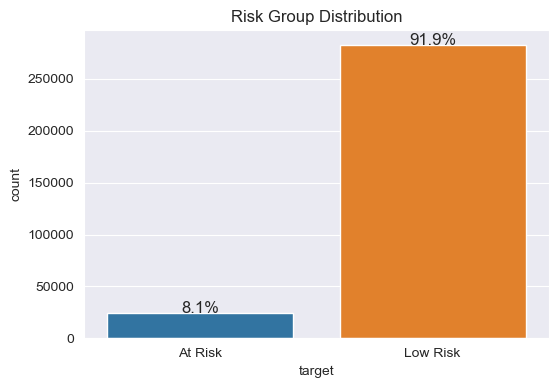

In [7]:
my_func.countplot_graph('Risk Group Distribution',
                        df=application_train,
                        column='target')

We can see that we have a very imbalanced dataset; only 8.1% of all instances 
are in the risk group. First, we'll plot additional demographic information to 
compare both groups. Let's start by its gender.

The count of 'XNA' is: 4


<Figure size 600x400 with 0 Axes>

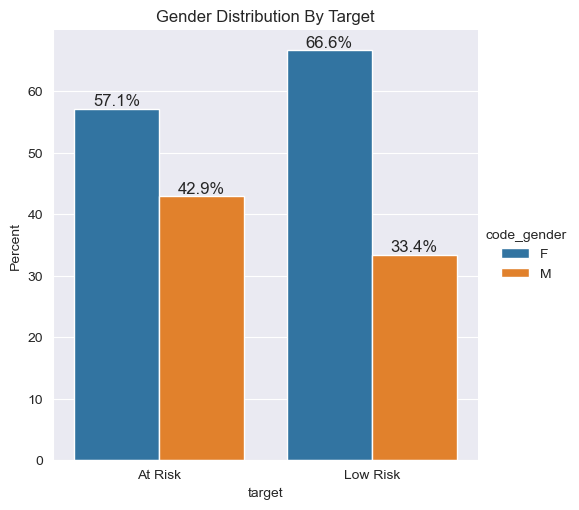

In [8]:
# Replacing 'XNA' values to F
xna_count = application_train['code_gender'].value_counts().get('XNA', 0)

print(f"The count of 'XNA' is: {xna_count}")

application_train['code_gender'] = (application_train['code_gender']
                                    .replace('XNA', 'F'))

my_func.proportion_graph('Gender Distribution By Target',
                         df=application_train,
                         column='target',
                         hue='code_gender')

From the graph above, we can see that females take more loans in our
dataset. In the low-risk group, the ratio between males and females is 
67/33%. In the risk group, the difference is slightly smaller at 57/43%. 
The next few graphs will provide some information about financial stability.

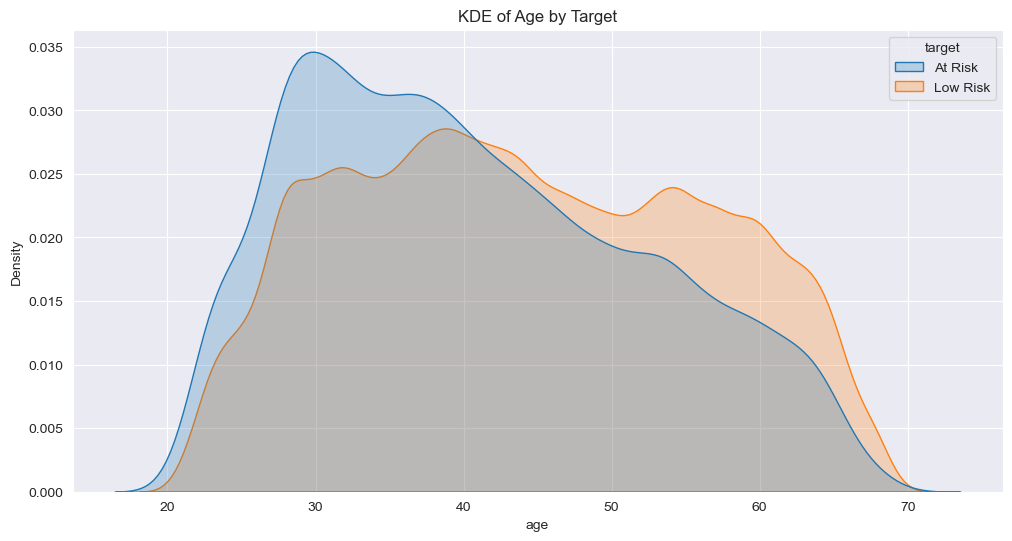

In [9]:
application_train['age'] = (application_train['days_birth'].abs() / 365).round()
my_func.plot_kde_by_target('KDE of Age by Target',
                           df=application_train,
                           column='age',
                           hue='target'
                           )
application_train.drop('days_birth', axis=1, inplace=True)

We can see that people distribution in a risk group is right-skewed and its 
peak in about 30yrs old.Low risk group is more univariate distributed.

<Figure size 600x400 with 0 Axes>

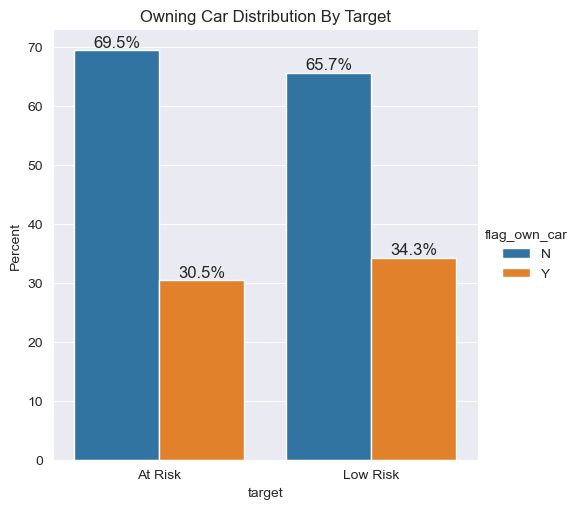

In [10]:
my_func.proportion_graph('Owning Car Distribution By Target',
                         df=application_train,
                         column='target',
                         hue='flag_own_car')

Here we can see that fewer people own a car. In the low-risk group,
only 34% of individuals own a car, while in the at-risk group, it's even
lower at 30.5%.

<Figure size 600x400 with 0 Axes>

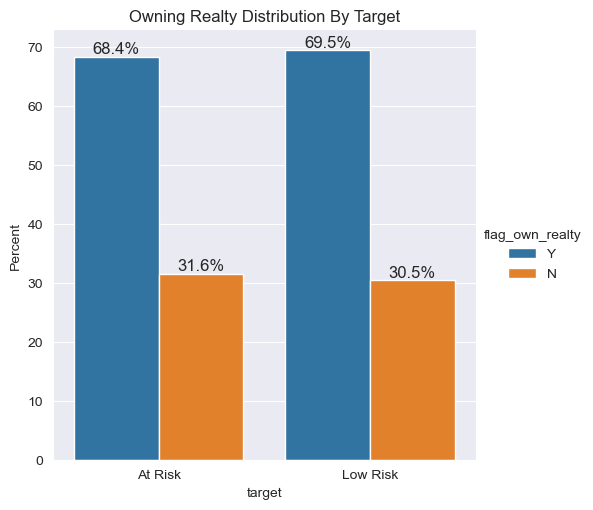

In [11]:
my_func.proportion_graph('Owning Realty Distribution By Target',
                         df=application_train,
                         column='target',
                         hue='flag_own_realty')

Unexpectedly, 68-70% of people in our dataset own realty. The percentages
are nearly equal in both groups. We should form a hypothesis test to
determine if this difference is statistically significant.

**Population:** Individuals in the application_train dataset

**Parameter of Interest:** $p_{risk} - p_{low-risk}$, difference of 
proportions.

**Null Hypothesis (H_0):** $p_{risk} = p_{low-risk} $ 
The proportion of individuals owning realty is the same in both risk and low-risk groups.

**Alternative Hypothesis (H_a):** $p_{risk} != p_{low-risk}$ 
The proportion of individuals owning realty is significantly different between the risk and low-risk groups.

We will set a confidence level of 95%: 
**alpha = 0.05**




In [12]:
grouped_counts = application_train.groupby('target')['flag_own_realty']\
                                                     .value_counts()

count_risk = grouped_counts.loc['At Risk', 'Y']
count_low_risk = grouped_counts.loc['Low Risk', 'Y']

n_risk = grouped_counts.loc['At Risk'].sum()
n_low_risk = grouped_counts.loc['Low Risk'].sum()

# Perform z-test
z_stat, p_value = proportions_ztest([count_risk, count_low_risk], 
                                    [n_risk, n_low_risk])

# Make conclusion
print(f"p_value: {p_value}")


p_value: 0.0006508043252169882


As our p value is less than 5%, we can reject null hypothesis and assume 
that the proportion of individuals owning realty is significantly different 
between the risk and low-risk groups. 

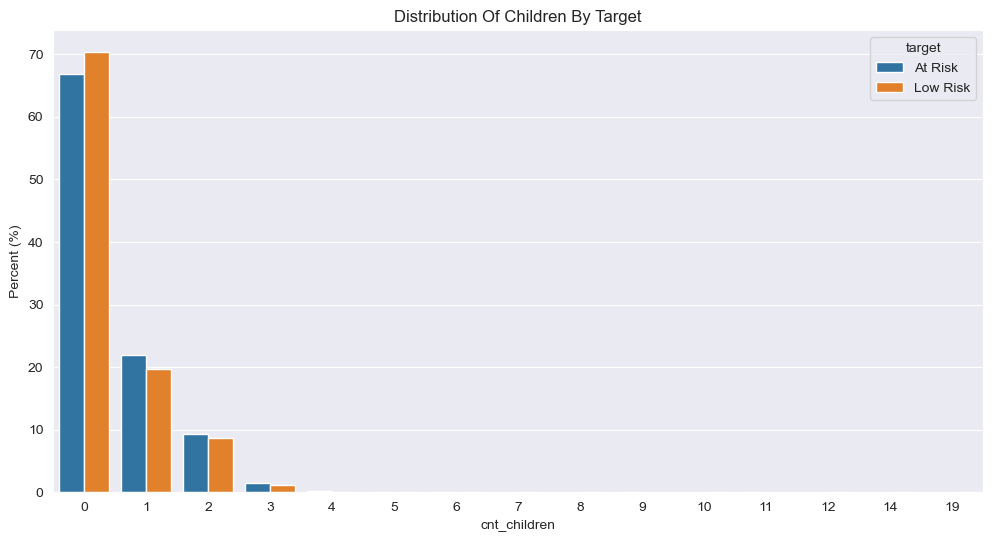

In [13]:
my_func.plot_distribution_by_target('Distribution Of Children By Target',
                                    df=application_train,
                                    column='cnt_children',
                                    hue='target')

We can see that most individuals have no children, particularly in the low-risk 
group. However, when individuals do have one or more children, a slightly higher 
percentage belong to the risk group.

Unknown family status count: 2


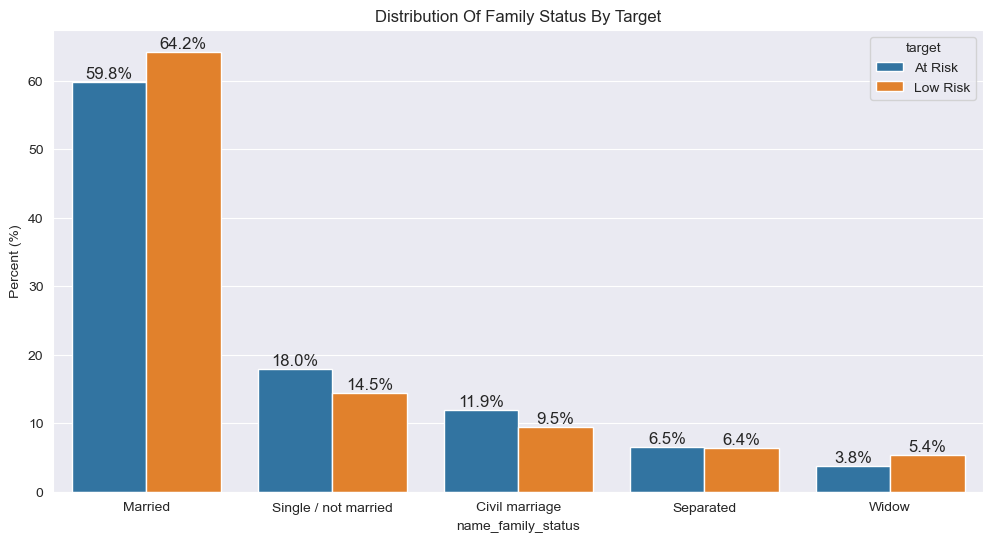

In [14]:
family_status_unknown_cnt = application_train['name_family_status'] \
                                .value_counts().get('Unknown')
print(f'Unknown family status count: {family_status_unknown_cnt}')

# Replace Unknown family status to Married.
application_train['name_family_status'] = (application_train['name_family_status']
                                            .replace('Unknown', 'Married'))

my_func.plot_distribution_by_target('Distribution Of Family Status By Target',
                                    df=application_train,
                                    column='name_family_status',
                                    hue='target',
                                    print_pct=True)

In the family status distribution, 60% in the risk group are married, compared 
to 64% in the low-risk group. Singles and civil unions are more common in 
the risk group. The separated category is similar in both groups, while the 
widow status is slightly higher in the risk group.

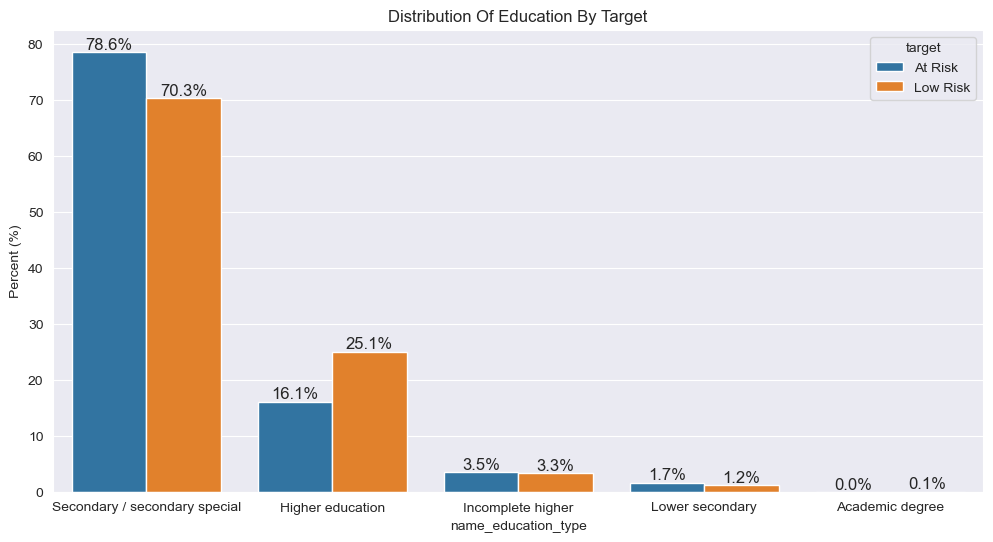

In [15]:
my_func.plot_distribution_by_target('Distribution Of Education By Target',
                                    df=application_train,
                                    column='name_education_type',
                                    hue='target',
                                    print_pct=True)

From the graph, 79% of the high-risk group have only secondary education,
compared to 70% in the low-risk group. Higher education is seen in 16% of 
the high-risk group and 25% of the low-risk group. Incomplete higher 
education, lower secondary, and academic degrees show similar distributions.


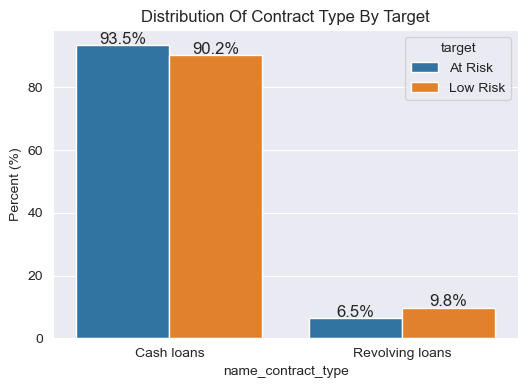

In [16]:
my_func.plot_distribution_by_target('Distribution Of Contract Type By Target',
                                    df=application_train,
                                    column='name_contract_type',
                                    hue='target',
                                    print_pct=True,
                                    figsize=(6,4))

We'll begin by analyzing the financial behavior of each group. In the risk group, 
93.5% have cash loans, compared to 90% in the low-risk group. Revolving loans 
constitute 6.5% in the risk group and 9.8% in the low-risk group.

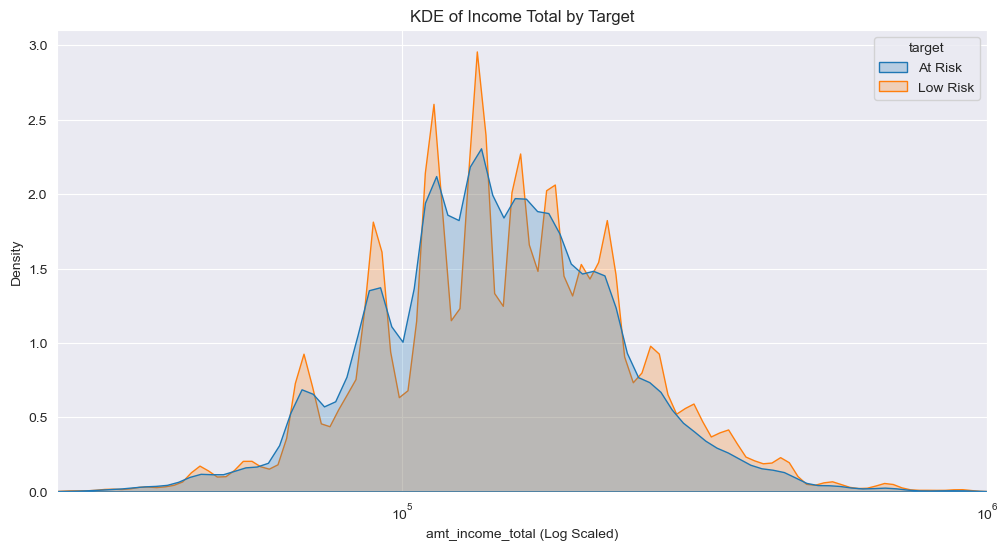

In [17]:
my_func.plot_kde_by_target('KDE of Income Total by Target',
                           df=application_train,
                           column='amt_income_total',
                           hue='target',
                           log_scale=True,
                           xlim=(application_train['amt_income_total'].min(), 1000000)
                           )

Our data is skewed, so we used a log-scale graph. It shows similar income 
distribution patterns in both groups. There we can observe peaks in both 
groups distributions are the same. The similarity in the distributions shows 
that income alone may not be a strong predictor for risk categorization.

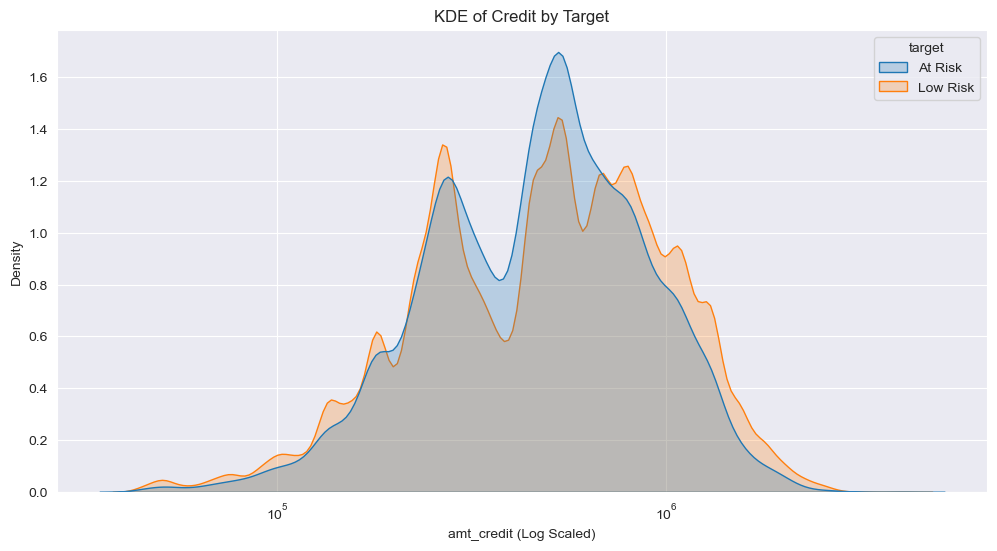

In [18]:
my_func.plot_kde_by_target('KDE of Credit by Target',
                           df=application_train,
                           column='amt_credit',
                           hue='target',
                           log_scale=True,
                           )

We can observe similar distributions for both the 'At Risk' and 'Low Risk' 
groups in credit amounts. The 'At Risk' group shows two main peaks, indicating 
two common credit ranges where individuals in this category frequently fall. 
The 'Low Risk' group got almost uniform distribution, suggesting that credit 
amounts for this group vary more widely. The similarities in the 
distributions show that credit amount alone may not be a strong predictor 
for risk categorization.

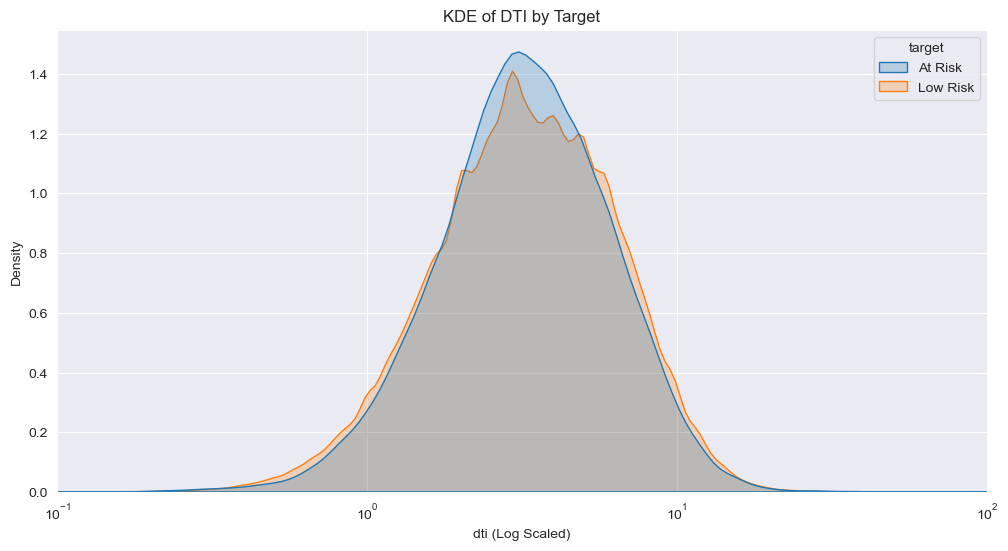

In [19]:
# Calculate debt to income
application_train['dti'] = (application_train['amt_credit'] / 
                            application_train['amt_income_total'])
my_func.plot_kde_by_target('KDE of DTI by Target',
                           df=application_train,
                           column='dti',
                           hue='target',
                           log_scale=True,
                           xlim=(0.1, 100)
                           )

Here we can see that distributions of both groups are almost equal, with one
 peak. We should look at the average values to see any differences.

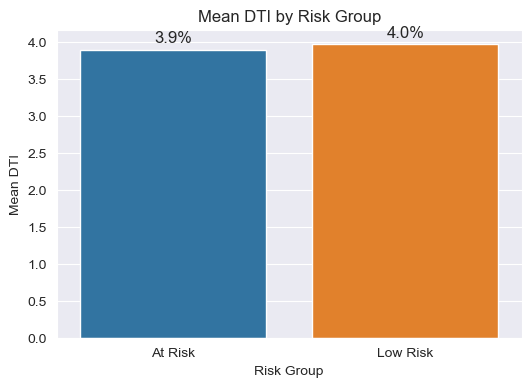

In [20]:
# Calculate mean DTI by risk group
mean_dti = application_train.groupby('target')['dti'].mean()
mean_dti_df = mean_dti.reset_index()


plt.figure(figsize=(6, 4))
ax = sns.barplot(x='target', y='dti', data=mean_dti_df)
plt.title('Mean DTI by Risk Group')
plt.xlabel('Risk Group')
plt.ylabel('Mean DTI')

# Annotating the bars with dti values
for p in ax.patches:
    pct = str(p.get_height().round(1)) + '%'
    pct_x = p.get_x() + p.get_width() / 2
    pct_y = p.get_height()+0.1
    ax.text(pct_x, pct_y, pct, ha='center', size=12)

plt.show();


**Population:** Individuals in the `application_train` dataset

**Parameter of Interest:** $( \mu_{risk} - \mu_{low-risk} $), difference of 
means for log-transformed DTI.

**Null Hypothesis \( H_0 \):** $(\mu_{risk} = \mu_{low-risk} $) 
The average log-transformed DTI is the same in both risk and low-risk groups.

**Alternative Hypothesis \( H_a \):** $(\mu_{risk} \neq \mu_{low-risk} $) 
The average log-transformed DTI is significantly different between the risk and low-risk groups.

**Confidence Level:** 
95% 
alpha = 0.05

In [21]:
# Log-transform the DTI values as we have skewed data
log_dti_risk = np.log(application_train.loc[application_train['target'] == 'At Risk', 'dti'])
log_dti_low_risk = np.log(application_train.loc[application_train['target'] == 'Low Risk', 'dti'])

# Perform the T-test
t_stat, p_value = ttest_ind(log_dti_risk, log_dti_low_risk)

print(f'P_value: {p_value}')

P_value: 0.7900837900136706


As our p_value is bigger than 5%, we can not reject our null hypothesis. So 
we assume that the average log-transformed DTI is the same in both risk and 
low-risk groups.

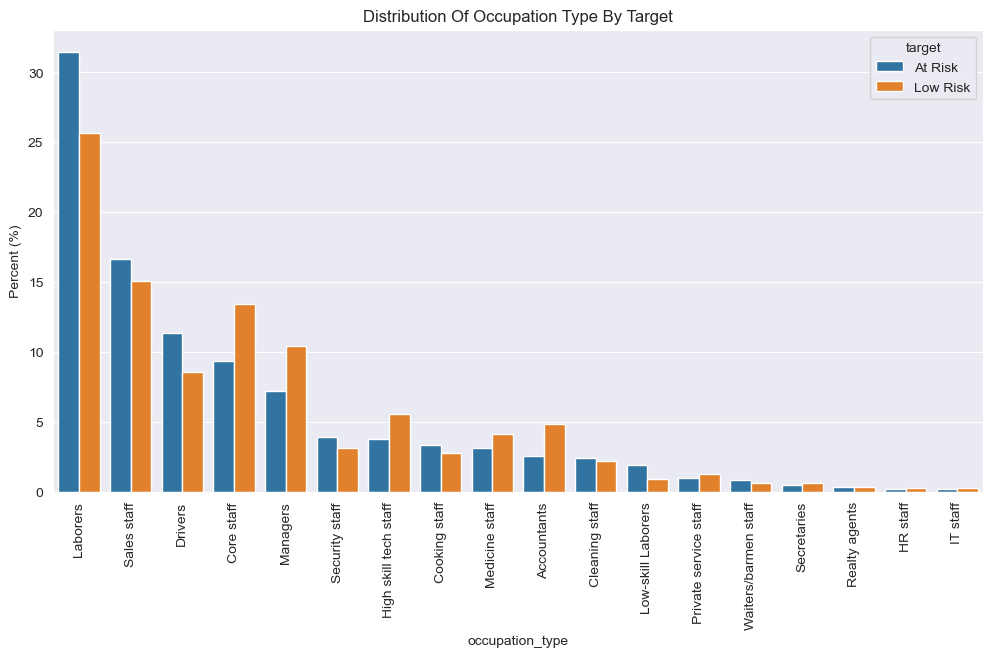

In [22]:
my_func.plot_distribution_by_target('Distribution Of Occupation Type By '
                                    'Target',
                                    df=application_train,
                                    column='occupation_type',
                                    hue='target',
                                    print_pct=False,
                                    rotation=90)

'Laborers,' 'Sales Staff,' and 'Core Staff' are the most common occupations. We 
observe that more individuals in the risk group are laborers, drivers, and 
sales staff. Conversely, the low-risk group predominantly consists of core 
staff, managers, high-skilled tech staff, and accountants.

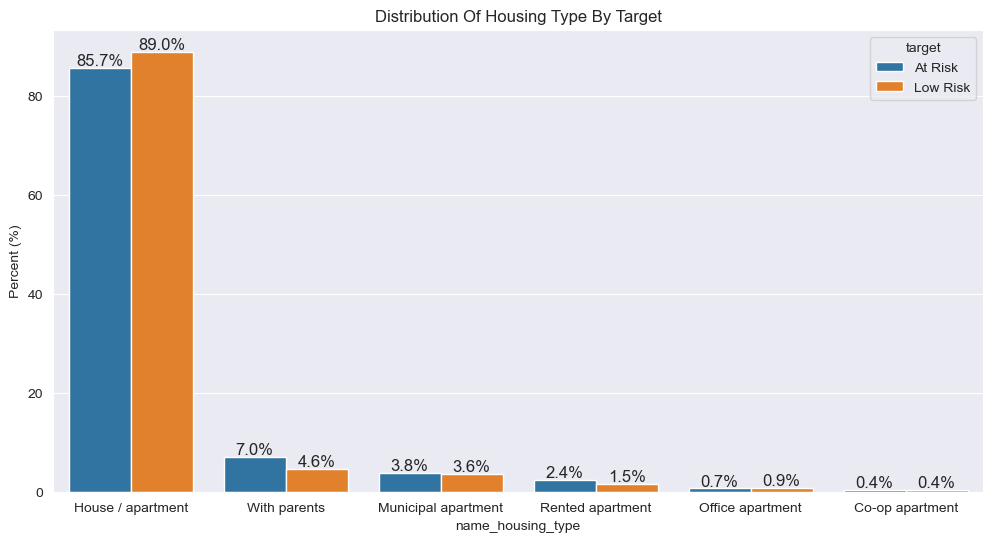

In [23]:
my_func.plot_distribution_by_target('Distribution Of Housing Type By Target',
                                    df=application_train,
                                    column='name_housing_type',
                                    hue='target',
                                    print_pct=True)

The distributions of housing type in both groups are almost identical. Most 
individuals live in houses or apartments, while the fewest reside in co-op 
apartments.

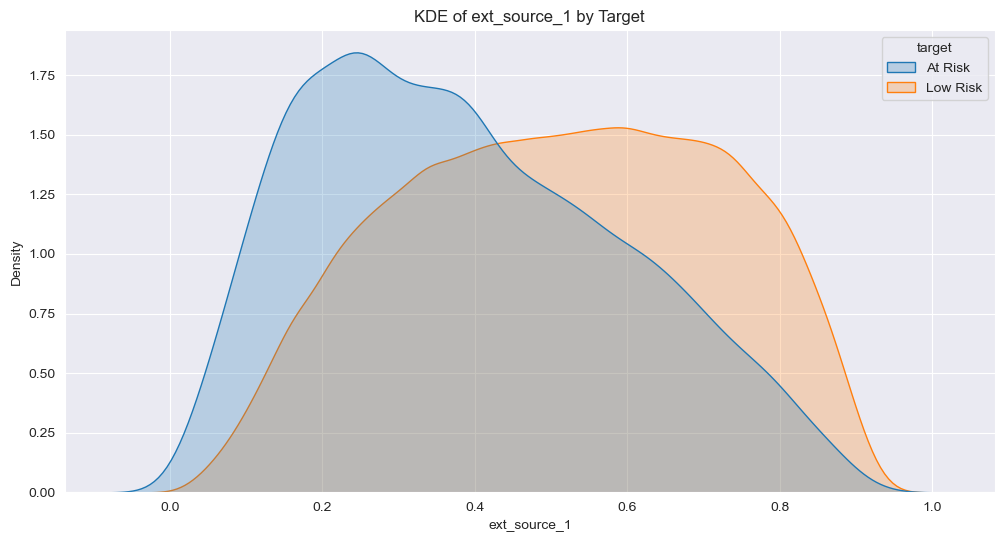

In [24]:
my_func.plot_kde_by_target('KDE of ext_source_1 by Target',
                           df=application_train,
                           column='ext_source_1',
                           hue='target'
                           )

The graph shows the distribution of 'ext_source1' for two risk groups. The 
"Low Risk" group has a right-skewed distribution with a distinct peak around 
0.2. In contrast, the "At Risk" group shows a more uniform distribution. 
This suggests that 'ext_source1' values around 0.2 are more common in the 
"Low Risk" group. This could be an important feature in our model training.

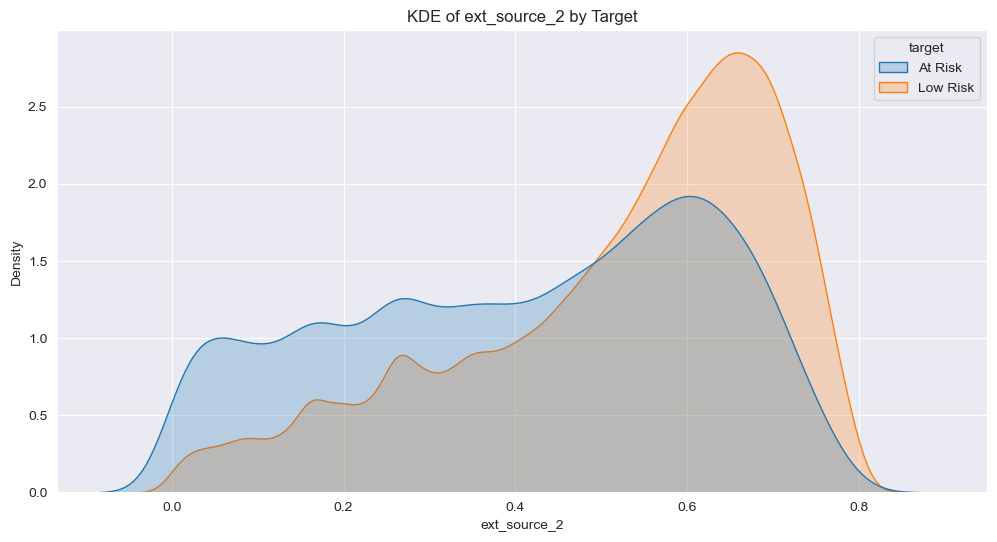

In [25]:
my_func.plot_kde_by_target('KDE of ext_source_2 by Target',
                           df=application_train,
                           column='ext_source_2',
                           hue='target'
                           )

The graph displays the distribution of 'ext_source2' for two risk groups. Both
distributions are left-skewed. The 'Low Risk' group has a peak around 0.7,
while the 'At Risk' group peaks at approximately 0.6.

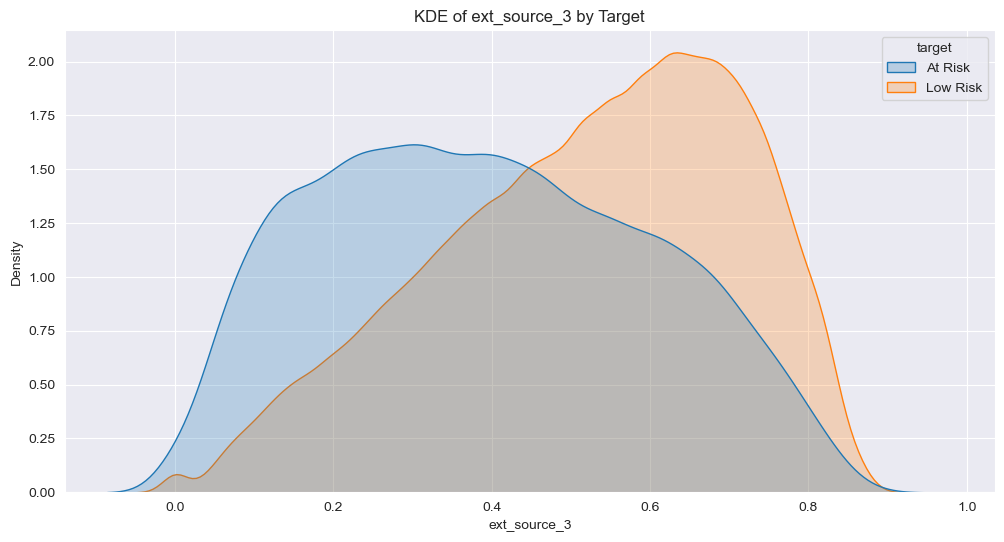

In [26]:
my_func.plot_kde_by_target('KDE of ext_source_3 by Target',
                           df=application_train,
                           column='ext_source_3',
                           hue='target'
                           )

The 'Low Risk' group has a notable peak around 0.3, while the 'At Risk' group 
has its peak around 0.7. This implies that 'ext_source3' values differ 
noticeably between the two risk groups.

posx and posy should be finite values
posx and posy should be finite values


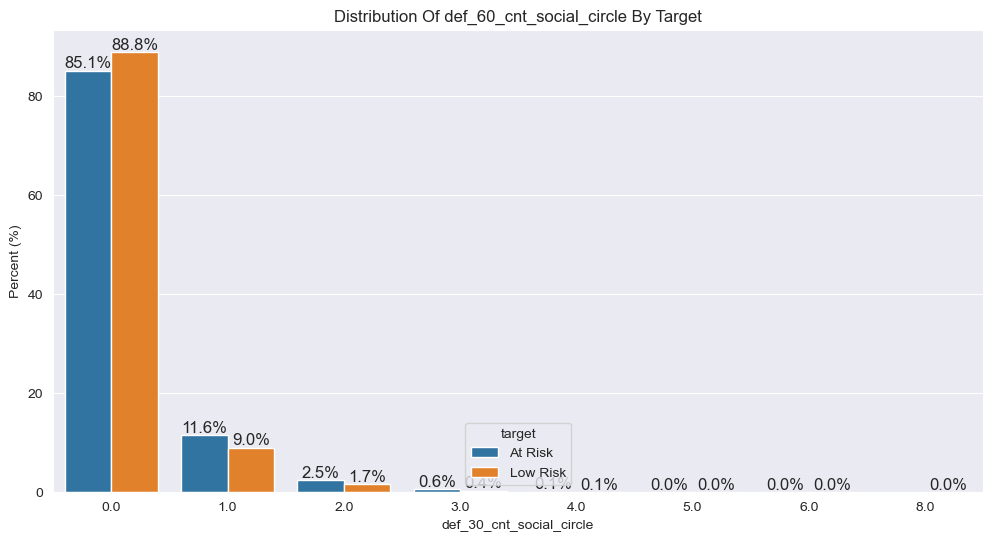

In [27]:
my_func.plot_distribution_by_target('Distribution Of def_60_cnt_social_circle'
                                    ' By Target',
                                    df=application_train[application_train['def_60_cnt_social_circle'] < 7],
                                    column='def_30_cnt_social_circle',
                                    hue='target',
                                    print_pct=True)

This graph illustrates the number of people in an individual's social circle 
who have had a 30-day delinquency on a loan. Most individuals have zero 
defaults in their social circle. However, when there is one or more default, 
a slightly higher percentage appears in the 'At Risk' group.

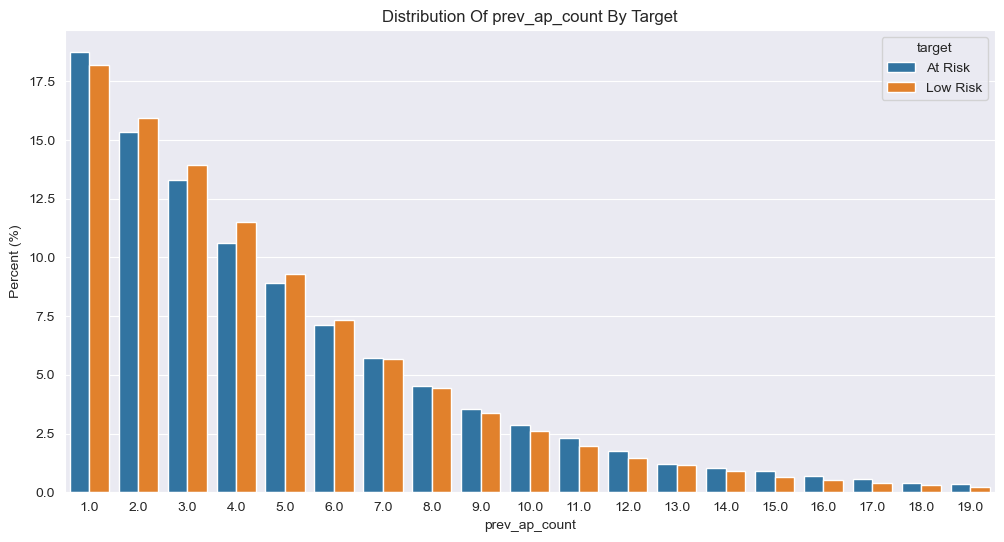

In [28]:
my_func.plot_distribution_by_target('Distribution Of prev_ap_count By Target',
                                    df=application_train[application_train['prev_ap_count'] < 20],
                                    column='prev_ap_count',
                                    hue='target',
                                    print_pct=False)

The graph represents the number of previous applications for each individual 
in both risk groups. We observe that individuals with 6 or fewer previous 
applications have a higher percentage in the 'Low Risk' group. Conversely, those 
with 7 or more previous applications have a slightly higher percentage in the
'At Risk' group.

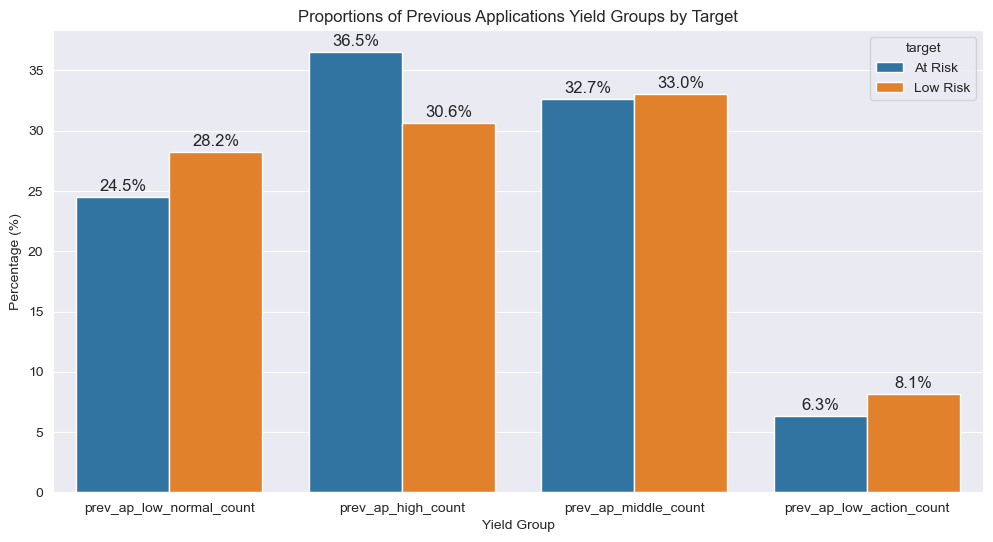

In [29]:
columns_to_sum = ['prev_ap_low_normal_count', 'prev_ap_high_count', 
                  'prev_ap_middle_count', 'prev_ap_low_action_count']

# Calculate the sum by target and normalize within each target group
sum_by_target = application_train.groupby('target')[columns_to_sum].sum()
normalized_sums = sum_by_target.div(sum_by_target.sum(axis=1), axis=0) * 100
normalized_sums.reset_index(inplace=True)

melted_df = pd.melt(normalized_sums, 
                    id_vars='target', 
                    value_vars=columns_to_sum, 
                    var_name='yield_group', 
                    value_name='percent_value')

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='yield_group', y='percent_value', hue='target', 
               data=melted_df)
for p in ax.patches:
    pct = str(p.get_height().round(1)) + '%'
    pct_x = p.get_x() + p.get_width() / 2
    pct_y = p.get_height() + 0.5
    ax.text(pct_x, pct_y, pct, ha='center', size=12)
    
plt.title('Proportions of Previous Applications Yield Groups by Target')
plt.xlabel('Yield Group')
plt.ylabel('Percentage (%)')
plt.show()


In this graph, we observe the percentage distribution of yield groups based on 
interest rates in previous loan applications. The 'At Risk' group has a 
noticeably higher percentage in the 'prev_ap_high_count' category, which could 
imply riskier loans with higher interest rates. In the other categories, the 
'Low Risk' group shows a slightly larger percentage, suggesting safer loans.

In [30]:
# Changing target values to more readable in graphs.
application_train['target'] = (application_train['target']
                               .replace({'At Risk': 1, 'Low Risk': 0}))

In [3]:
#application_train.to_parquet('application_train5.parquet')
application_train = pd.read_parquet('application_train5.parquet')

### Data Cleaning
The main task of this section is to tackle missing data to ensure the 
reliability of our subsequent analyses.

Objectives:

* Identify columns with missing data and assess the extent of the issue.
* Investigate if the missingness is random or follows some pattern.
* For columns where it makes sense, impute missing values using statistical methods.
* In cases where imputation isn't feasible or meaningful, consider removing the 
affected rows or columns.
* After handling missing data, verify that the dataset is clean and ready for 
further analysis.

In [4]:
application_train.head(10)

sk_id_curr  target name_contract_type code_gender flag_own_car  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   
5      100008       0         Cash loans           M            N   
6      100009       0         Cash loans           F            Y   
7      100010       0         Cash loans           M            Y   
8      100011       0         Cash loans           F            N   
9      100012       0    Revolving loans           M            N   

  flag_own_realty  cnt_children  amt_income_total  amt_credit  amt_annuity  \
0               Y             0        202500.000  406597.500    24700.500   
1               N             0        270000.000 1293502.500    35698.500   
2               Y             0         67500.000  135000.000     6750.000   
3               Y             0        135000.000  312682.500    29686.500   
4               Y             0        121500.000  513000.000    21865.500   
5               Y             0         99000.000  490495.500    27517.500   
6               Y             1        171000.000 1560726.000    41301.000   
7               Y             0        360000.000 1530000.000    42075.000   
8               Y             0        112500.000 1019610.000    33826.500   
9               Y             0        135000.000  405000.000    20250.000   

   amt_goods_price  name_type_suite      name_income_type  \
0       351000.000    Unaccompanied               Working   
1      1129500.000           Family         State servant   
2       135000.000    Unaccompanied               Working   
3       297000.000    Unaccompanied               Working   
4       513000.000    Unaccompanied               Working   
5       454500.000  Spouse, partner         State servant   
6      1395000.000    Unaccompanied  Commercial associate   
7      1530000.000    Unaccompanied         State servant   
8       913500.000         Children             Pensioner   
9       405000.000    Unaccompanied               Working   

             name_education_type    name_family_status  name_housing_type  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   
5  Secondary / secondary special               Married  House / apartment   
6               Higher education               Married  House / apartment   
7               Higher education               Married  House / apartment   
8  Secondary / secondary special               Married  House / apartment   
9  Secondary / secondary special  Single / not married  House / apartment   

   region_population_relative  days_employed  days_registration  \
0                       0.019           -637          -3648.000   
1                       0.004          -1188          -1186.000   
2                       0.010           -225          -4260.000   
3                       0.008          -3039          -9833.000   
4                       0.029          -3038          -4311.000   
5                       0.036          -1588          -4970.000   
6                       0.036          -3130          -1213.000   
7                       0.003           -449          -4597.000   
8                       0.019         365243          -7427.000   
9                       0.020          -2019         -14437.000   

   days_id_publish  own_car_age  flag_mobil  flag_emp_phone  flag_work_phone  \
0            -2120          NaN           1   

In [5]:
application_train.describe()

sk_id_curr     target  cnt_children  amt_income_total  amt_credit  \
count  307511.000 307511.000    307511.000        307511.000  307511.000   
mean   278180.519      0.081         0.417        168797.919  599026.000   
std    102790.175      0.272         0.722        237123.146  402490.777   
min    100002.000      0.000         0.000         25650.000   45000.000   
25%    189145.500      0.000         0.000        112500.000  270000.000   
50%    278202.000      0.000         0.000        147150.000  513531.000   
75%    367142.500      0.000         1.000        202500.000  808650.000   
max    456255.000      1.000        19.000     117000000.000 4050000.000   

       amt_annuity  amt_goods_price  region_population_relative  \
count   307499.000       307233.000                  307511.000   
mean     27108.574       538396.207                       0.021   
std      14493.737       369446.461                       0.014   
min       1615.500        40500.000                       0.000   
25%      16524.000       238500.000                       0.010   
50%      24903.000       450000.000                       0.019   
75%      34596.000       679500.000                       0.029   
max     258025.500      4050000.000                       0.073   

       days_employed  days_registration  days_id_publish  own_car_age  \
count     307511.000         307511.000       307511.000   104582.000   
mean       63815.046          -4986.120        -2994.202       12.061   
std       141275.767           3522.886         1509.450       11.945   
min       -17912.000         -24672.000        -7197.000        0.000   
25%        -2760.000          -7479.500        -4299.000        5.000   
50%        -1213.000          -4504.000        -3254.000        9.000   
75%         -289.000          -2010.000        -1720.000       15.000   
max       365243.000              0.000            0.000       91.000   

       flag_mobil  flag_emp_phone  flag_work_phone  flag_cont_mobile  \
count  307511.000      307511.000       307511.000        307511.000   
mean        1.000           0.820            0.199             0.998   
std         0.002           0.384            0.400             0.043   
min         0.000           0.000            0.000             0.000   
25%         1.000           1.000            0.000             1.000   
50%         1.000           1.000            0.000             1.000   
75%         1.000           1.000            0.000             1.000   
max         1.000           1.000            1.000             1.000   

       flag_phone  flag_email  cnt_fam_members  region_rating_client  \
count  307511.000  307511.000       307509.000            307511.000   
mean        0.281       0.057            2.153                 2.052   
std         0.450       0.231            0.911                 0.509   
min         0.000       0.000            1.000                 1.000   
25%         0.000       0.000            2.000                 2.000   
50%         0.000       0.000            2.000                 2.000   
75%         1.000       0.000            3.000                 2.000   
max         1.000       1.000           20.000                 3.000   

       region_rating_client_w_city  hour_appr_process_start  \
count                   307511.000               307511.000   
mean                         2.032                   12.063   
std                          0.503                    3.266   
min                          1.000                    0.000   
25%                          2.000                   10.000   
50%                          2.000                   12.000   
75%                          2.000                   14.000   
max                          3.000                   23.000   

       reg_region_not_live_region  reg_region_not_work_region  \
count                  307511.000                  307511.000   
mean                        0.015                       0.051   

<Axes: >

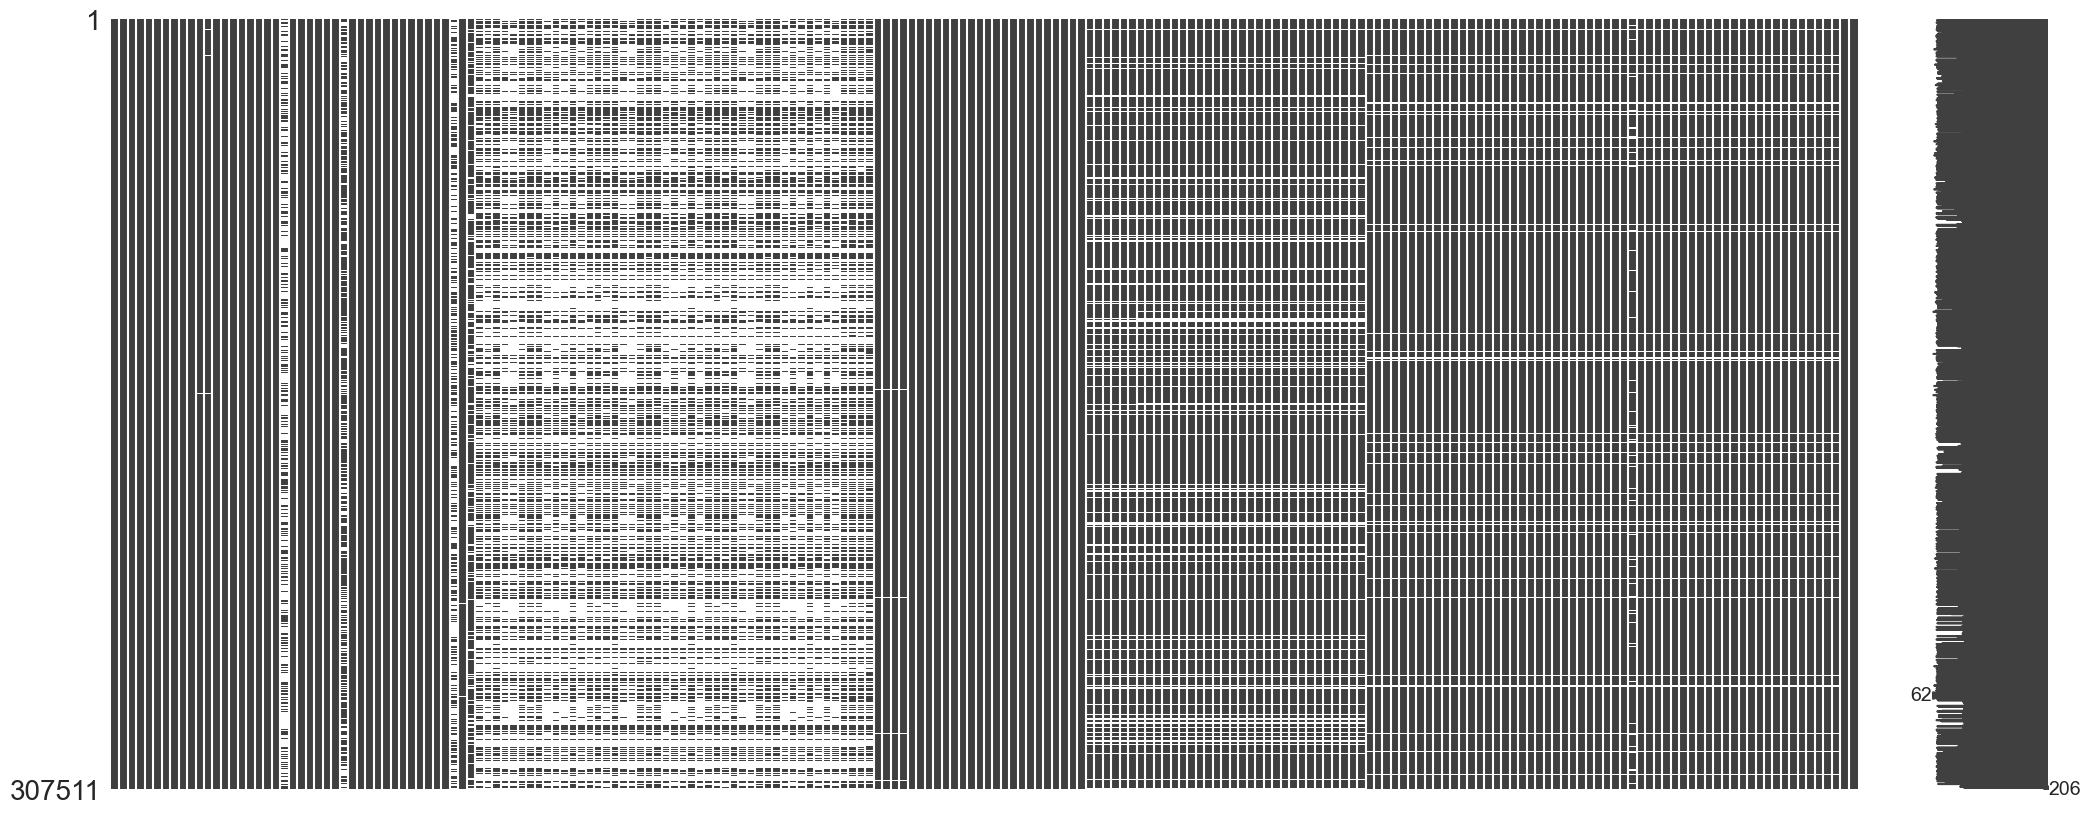

In [6]:
msno.matrix(application_train)

<Axes: >

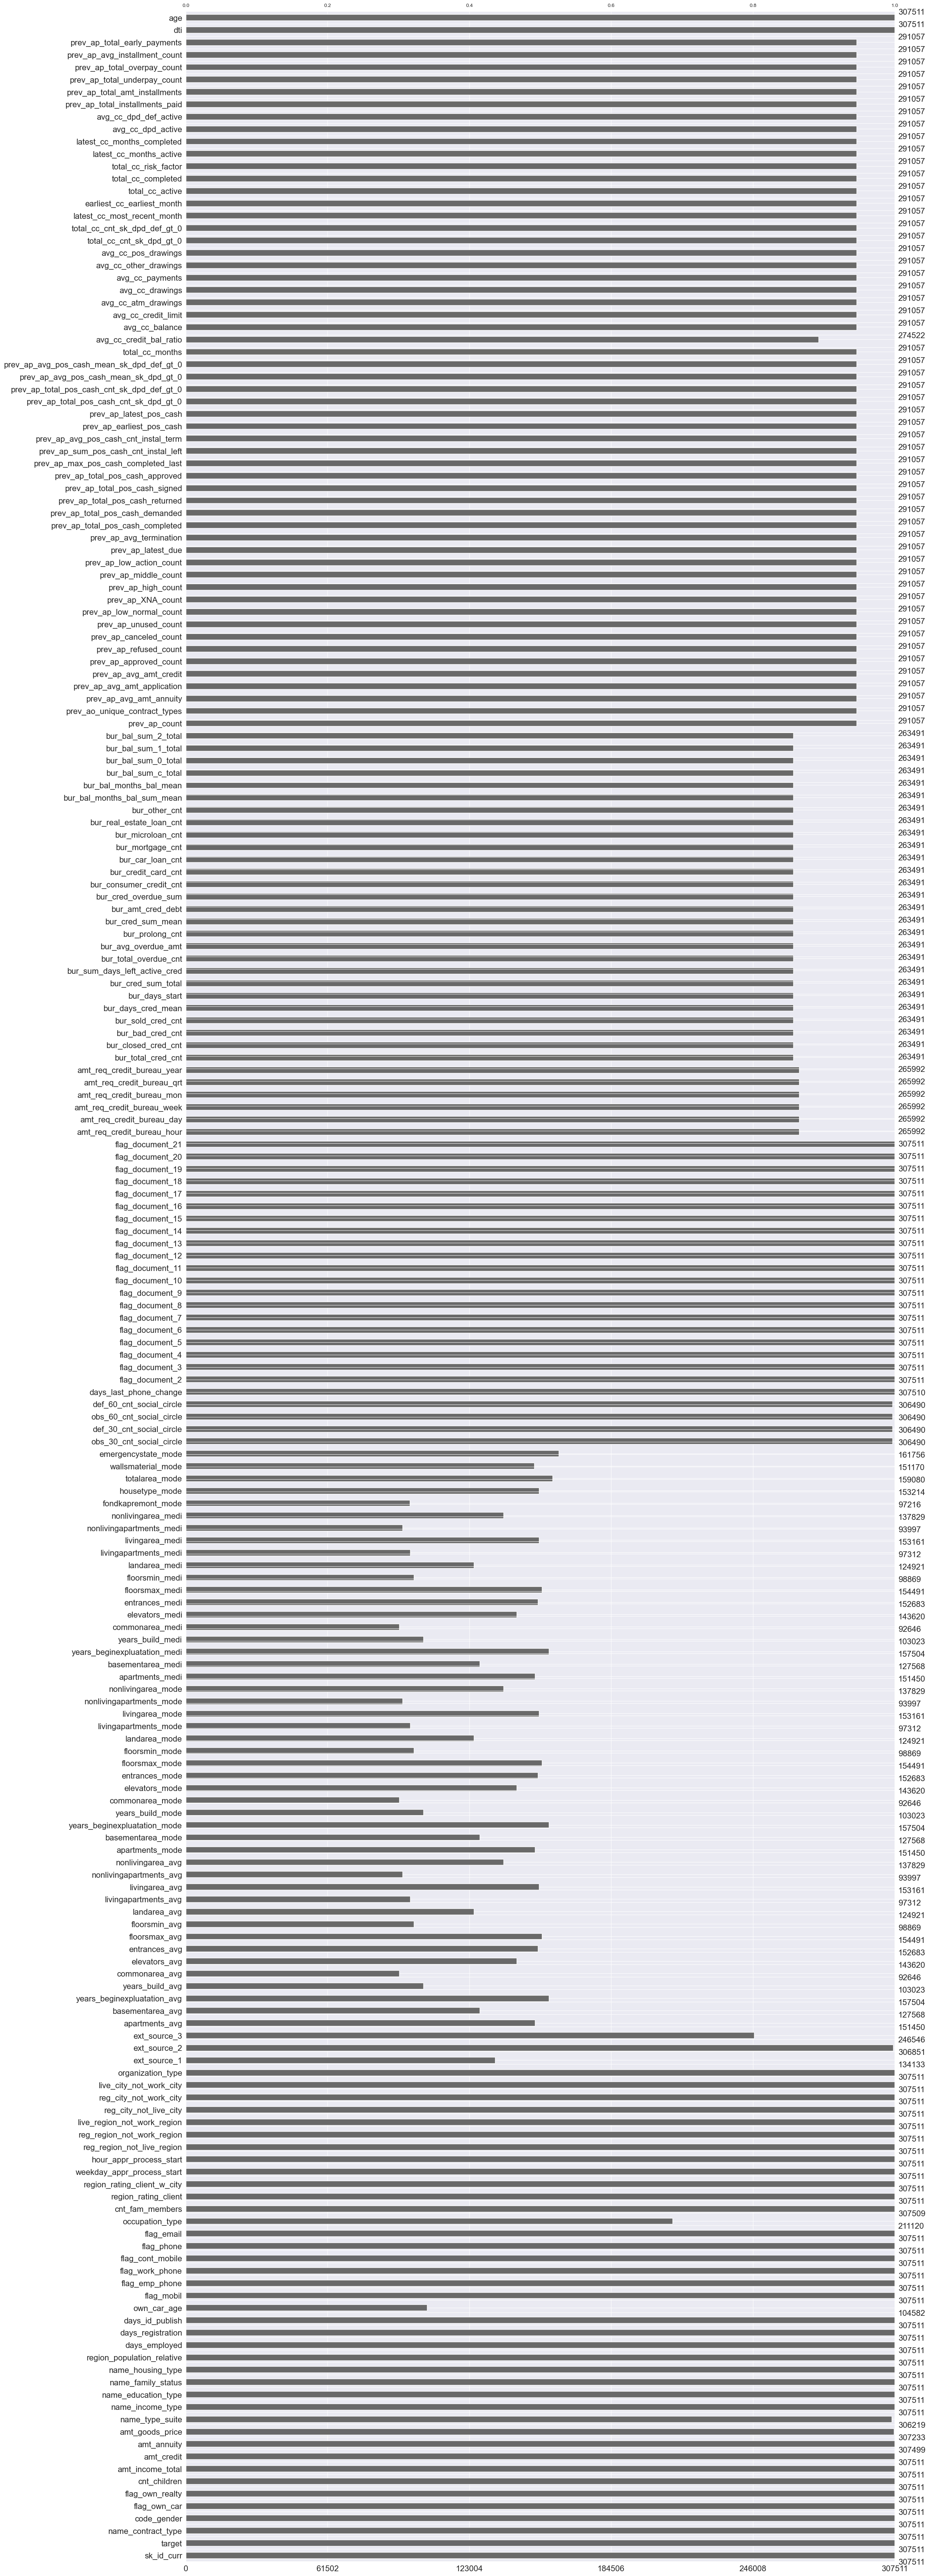

In [7]:
msno.bar(application_train)

At first, we should impute ext_sourced missing values, and keep distributions
 of each group the same.

In [8]:
ext_sources = ['ext_source_1', 'ext_source_2', 'ext_source_3']

for ext_source in ext_sources:

    for target_class in [0, 1]:

        non_missing_data = application_train\
        .loc[application_train['target'] == target_class, ext_source].dropna()
        
        missing_indices = application_train[(application_train['target']
            == target_class) & (application_train[ext_source].isna())].index

        # Impute missing values with random sampling
        application_train.loc[missing_indices, ext_source] = np.random\
            .choice(non_missing_data, size=len(missing_indices))


In [9]:
# Fill missing values for these columns
application_train.fillna({
    'own_car_age': -1, 
    'occupation_type': 'Laborers',
    'name_type_suite': 'Unaccompanied'
                          }, inplace=True)

# assume that 365243 value is missing, as it not possible, replace with 0
application_train['days_employed'].replace(365243, 0, inplace=True)

# Replace inf values to nan
application_train['avg_cc_credit_bal_ratio'].replace([np.inf, -np.inf], 
                                                     np.nan, 
                                                     inplace=True)


In [10]:
# Filter columns with more than 40% missing values
missing_data = application_train.isna().mean().round(4) * 100
columns_with_many_missing = missing_data[missing_data > 40]
columns_with_many_missing

apartments_avg                 50.750
basementarea_avg               58.520
years_beginexpluatation_avg    48.780
years_build_avg                66.500
commonarea_avg                 69.870
elevators_avg                  53.300
entrances_avg                  50.350
floorsmax_avg                  49.760
floorsmin_avg                  67.850
landarea_avg                   59.380
livingapartments_avg           68.350
livingarea_avg                 50.190
nonlivingapartments_avg        69.430
nonlivingarea_avg              55.180
apartments_mode                50.750
basementarea_mode              58.520
years_beginexpluatation_mode   48.780
years_build_mode               66.500
commonarea_mode                69.870
elevators_mode                 53.300
entrances_mode                 50.350
floorsmax_mode                 49.760
floorsmin_mode                 67.850
landarea_mode                  59.380
livingapartments_mode          68.350
livingarea_mode                50.190
nonlivingapa

As these columns have too many missing values, we should remove them.

In [11]:
# Dropping columns with more than 40% missing values
application_train.drop(columns=columns_with_many_missing.index, inplace=True)

In [12]:
application_train.isna().sum().sort_values(ascending=False)

bur_days_start             44020
bur_bal_sum_0_total        44020
bur_total_cred_cnt         44020
bur_closed_cred_cnt        44020
bur_bad_cred_cnt           44020
                           ...  
organization_type              0
live_city_not_work_city        0
reg_city_not_work_city         0
reg_city_not_live_city         0
age                            0
Length: 159, dtype: int64

In [13]:
application_train.fillna(0, inplace=True)

In [14]:
application_train.isna().sum().sum()

0

## Feature Engineering

The overarching aim of this section is to refine the dataframe by creating 
valuable features and eliminating the irrelevant ones.
 
objectives:

* Feature Creation: Design new features that can add predictive power to the model
* Feature Selection: Identify and remove features with zero variances as they 
won't be helpful for the model. Use mutual information to identify and remove 
the least informative features.

### Feature Creation

Create some new features that might be beneficial

In [15]:
application_train.shape

(307511, 159)

In [16]:
eps = 1e-10


# For logarithm transformations
application_train['log_dti'] = np.log(
        application_train['dti'] + eps)
application_train['log_amt_income_total'] = np.log(
        application_train['amt_income_total'] + eps)
application_train['log_amt_credit'] = np.log(
        application_train['amt_credit'] + eps)
application_train['log_amt_annuity'] = np.log(
        application_train['amt_annuity'] + eps)
application_train['log_amt_goods_price'] = np.log(
        application_train['amt_goods_price'] + eps)

application_train['flag_contact'] = (
        application_train['flag_mobil'] +
        application_train['flag_emp_phone'] +
        application_train['flag_work_phone'] +
        application_train['flag_cont_mobile'] +
        application_train['flag_phone'] +
        application_train['flag_email']
)

application_train['amt_inc_person'] = (
        application_train['amt_income_total'] /
        (application_train['cnt_fam_members'] + eps)
)

application_train['credit_per_child'] = (
        application_train['amt_credit'] /
        (application_train['cnt_children'] + 1)
)

application_train['income_to_annuity_ratio'] = (
        application_train['amt_income_total'] /
        (application_train['amt_annuity'] + eps)
)

application_train['income_to_credit_ratio'] = (
        application_train['amt_income_total'] /
        (application_train['amt_credit'] + eps)
)

application_train['credit_to_annuity_ratio'] = (
        application_train['amt_credit'] /
        (application_train['amt_annuity'] + eps)
)

application_train['credit_to_goods_ratio'] = (
        application_train['amt_credit'] /
        (application_train['amt_goods_price'] + eps)
)

application_train['income_to_goods_ratio'] = (
        application_train['amt_income_total'] /
        (application_train['amt_goods_price'] + eps)
)

application_train['total_geo_discrepancies'] = (
        application_train['reg_region_not_live_region'] +
        application_train['reg_region_not_work_region'] +
        application_train['live_region_not_work_region'] +
        application_train['reg_city_not_live_city'] +
        application_train['reg_city_not_work_city'] +
        application_train['live_city_not_work_city']
)

application_train['ext_sources_sum'] = (
        application_train['ext_source_1'] +
        application_train['ext_source_2'] +
        application_train['ext_source_3']
)

application_train['ext_sources_mean'] = (
    application_train[['ext_source_1', 'ext_source_2', 'ext_source_3']].mean(axis=1)
)

application_train['ext_sources_prod'] = (
        application_train['ext_source_1'] *
        application_train['ext_source_2'] *
        application_train['ext_source_3']
)

application_train['ext_source_1_times_income'] = (
        application_train['ext_source_1'] *
        application_train['amt_income_total']
)

application_train['ext_source_2_times_income'] = (
        application_train['ext_source_2'] *
        application_train['amt_income_total']
)

application_train['ext_source_3_times_income'] = (
        application_train['ext_source_3'] *
        application_train['amt_income_total']
)

application_train['ext_source_1_squared'] = application_train['ext_source_1'] ** 2
application_train['ext_source_2_squared'] = application_train['ext_source_2'] ** 2
application_train['ext_source_3_squared'] = application_train['ext_source_3'] ** 2

flag_document_columns = [f'flag_document_{i}' for i in range(2, 22)]
application_train['sum_flag_documents'] = application_train[flag_document_columns].sum(axis=1)

application_train['total_prev_credits'] = (application_train['prev_ap_count'] + 
                                           application_train['bur_total_cred_cnt'])

application_train['total_risk_counts'] = (
        application_train['prev_ap_refused_count'] +
        application_train['prev_ap_canceled_count'] +
        application_train['prev_ap_unused_count'] +
        application_train['bur_bad_cred_cnt'] +
        application_train['bur_sold_cred_cnt'] +
        application_train['total_cc_risk_factor']
)


In [17]:
application_train.shape

(307511, 185)

After creating new features, now we have 185columns in our dataset. There 
are 26new columns.

### Feature selection

In [31]:
# Quasi-constant and constant features where at least 99.7% of data is constant
sel_const = DropConstantFeatures(tol=0.997, 
                                 variables=None, 
                                 missing_values='raise')
sel_const.fit(application_train)
print(f'Quasi-constant features : {sel_const.features_to_drop_}')

Quasi-constant features : ['flag_mobil', 'flag_cont_mobile', 'flag_document_2', 'flag_document_4', 'flag_document_7', 'flag_document_10', 'flag_document_12', 'flag_document_14', 'flag_document_15', 'flag_document_17', 'flag_document_19', 'flag_document_20', 'flag_document_21', 'bur_bad_cred_cnt', 'bur_real_estate_loan_cnt', 'prev_ap_total_pos_cash_demanded', 'total_cc_risk_factor']


These columns may contain relevant information for predicting our target 
variable, so I've decided to keep them. I also tested with a tolerance of 1 
and confirmed that there are no completely constant features.

In [32]:
# Find a duplicated columns
sel_duplicates = DropDuplicateFeatures(variables=None, missing_values='raise')
sel_duplicates.fit(application_train)
print(f'Duplicated features will be dropped: {sel_duplicates.features_to_drop_}')

Duplicated features will be dropped: set()


As there are no duplicated features, we can proceed to the next step - mutual 
information score.

In [32]:
X = application_train.drop('target', axis=1)
y = application_train['target']

# Splitting dataset to training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y,
                                                    test_size=0.3,
                                                    stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp,
                                                y_temp,
                                                test_size=0.5,
                                                stratify=y_temp)

print("X_train shape: ", X_train.shape)
print("X_val shape: ", X_val.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (215257, 184)
X_val shape:  (46127, 184)
X_test shape:  (46127, 184)


In [33]:
# Calculating mutual information scores
mi_scores = my_func.make_mi_scores(X_train, y_train)
mi_scores

ext_source_1_squared           0.090
ext_source_1                   0.090
flag_cont_mobile               0.041
flag_emp_phone                 0.040
flag_document_3                0.039
                                ... 
bur_sold_cred_cnt              0.000
bur_prolong_cnt                0.000
bur_amt_cred_debt              0.000
total_cc_cnt_sk_dpd_def_gt_0   0.000
bur_real_estate_loan_cnt       0.000
Length: 184, dtype: float64

In [34]:
# Dropping columns with zero mutual information from each dataset
columns_to_remove = mi_scores[mi_scores == 0].index.tolist()

X_train.drop(columns=columns_to_remove, inplace=True)
X_val.drop(columns=columns_to_remove, inplace=True)
X_test.drop(columns=columns_to_remove, inplace=True)

# Print the new shapes to confirm
print("X_train shape: ", X_train.shape)
print("X_val shape: ", X_val.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (215257, 157)
X_val shape:  (46127, 157)
X_test shape:  (46127, 157)


After removing features with mutual score 0, there are 157 features left. Now
 we should perform recursive feature elimination using feature engine to 
reduce dimensionality with little or no prediction loss.

In [4]:
# Copy original datasets
X_train_rfe = X_train.copy()
X_val_rfe = X_val.copy()

# Get Column names of categorical features.
categorical_features_rfe = (
    X_train_rfe.select_dtypes(include=['object']).columns.tolist()
)

encoder_rfe = LabelEncoder()

# Encoding categorical features
for feature in categorical_features_rfe:
    X_train_rfe[feature] = encoder_rfe.fit_transform(X_train_rfe[feature])
    X_val_rfe[feature] = encoder_rfe.transform(X_val_rfe[feature])
    
# Initialize LightGBM classifier
rfe_model = LGBMClassifier(n_estimators=100,
                           random_state=10,
                           class_weight='balanced',
                           n_jobs=-1,
                           device='gpu',
                           metric='auc',
                           verbosity=0,
)

# RFE process with modified scoring metric
sel_rec = RecursiveFeatureElimination(
    variables=None,
    estimator=rfe_model,
    scoring='roc_auc',
    threshold=0.0003,
    cv=3 
)

# Fit RFE
sel_rec.fit(X_train_rfe, y_train)

RecursiveFeatureElimination(estimator=LGBMClassifier(class_weight='balanced',
                                                     device='gpu', metric='auc',
                                                     n_jobs=-1, random_state=10,
                                                     verbosity=0),
                            threshold=0.0003)

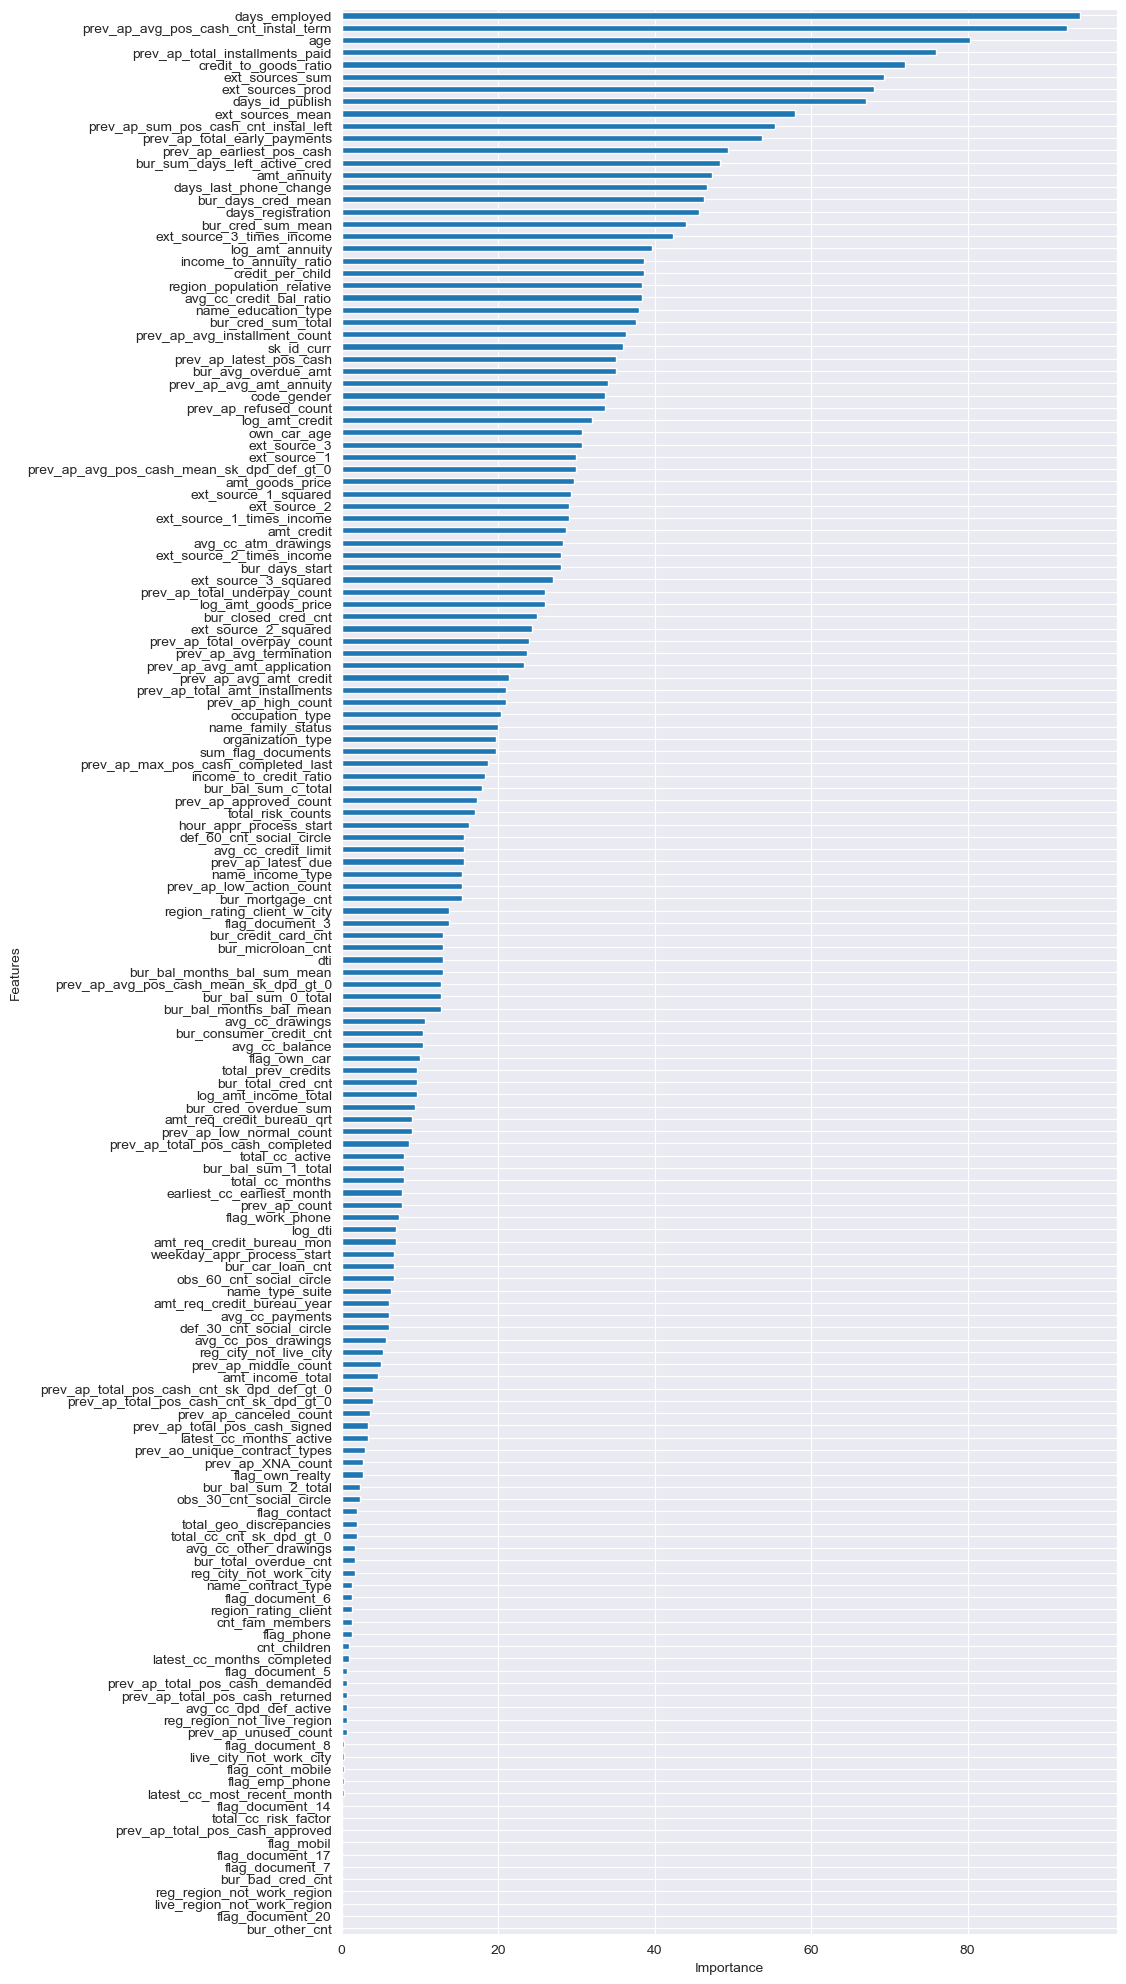

In [6]:
# importance of all features based of initial model

sel_rec.feature_importances_.plot.barh(figsize=(10,25))
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

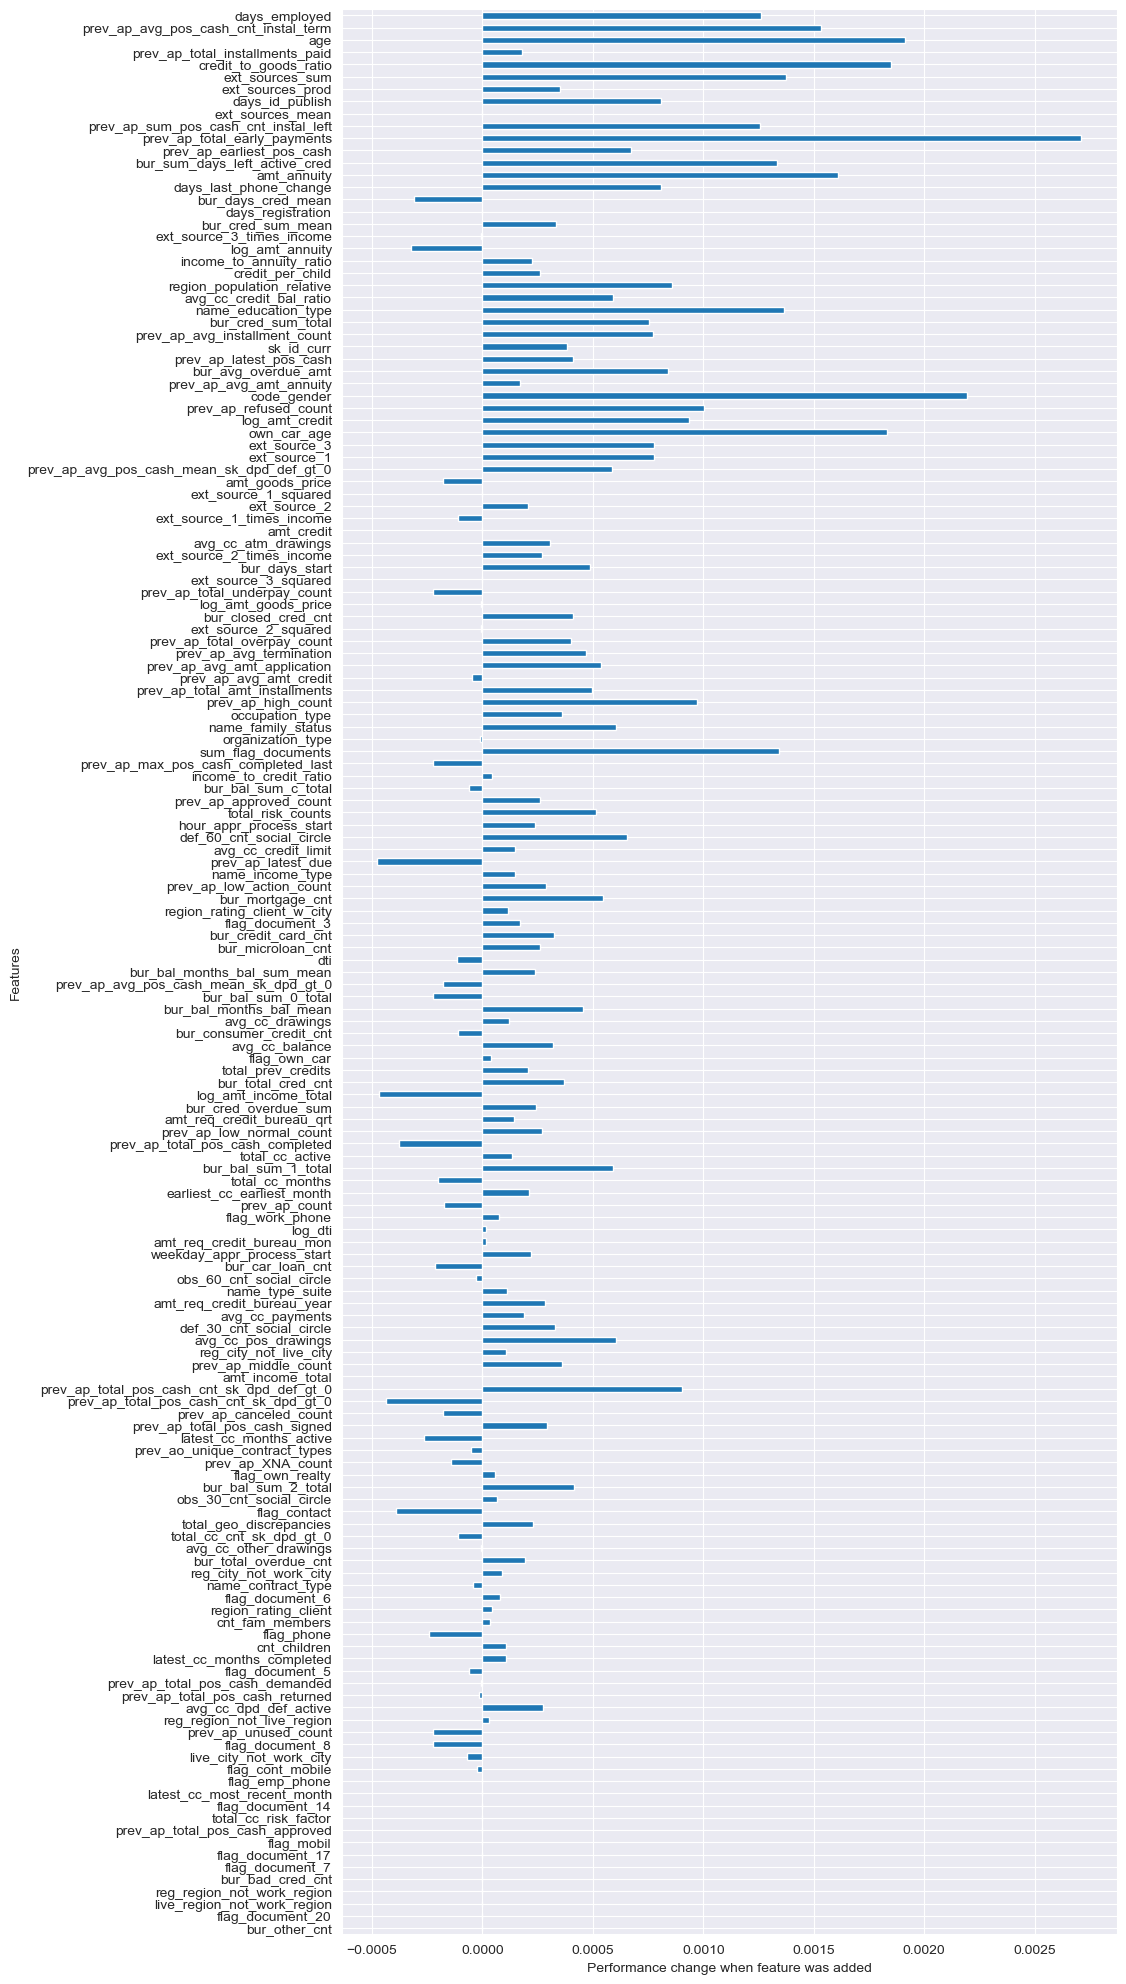

In [9]:
pd.Series(sel_rec.performance_drifts_).plot.barh(figsize=(10,25))
plt.ylabel('Features')
plt.xlabel('Performance change when feature was added')
plt.show()

In [10]:
# Features will be dropped
len(sel_rec.features_to_drop_)

104

In [11]:
# Select important features
X_train_rfe = sel_rec.transform(X_train_rfe)
X_val_rfe = sel_rec.transform(X_val_rfe)

# Fit the model with the selected features for comparison
rfe_model.fit(X_train_rfe, y_train)

y_pred_val = rfe_model.predict_proba(X_val_rfe)
roc_auc_per_class_val = roc_auc_score(y_val, y_pred_val[:, 1])

print('ROC AUC score before removing features:', sel_rec.initial_model_performance_)
print('ROC AUC score after removing features:', roc_auc_per_class_val)

ROC AUC score before removing features: 0.7990413588422838
ROC AUC score after removing features: 0.797417150454441


After removing 104 features with the lowest performance change, we can observe 
a 0.002 drop of ROC_AUC score. As we are satisfied with these results, we can 
proceed to train main model.

In [12]:
features_to_drop = sel_rec.features_to_drop_

X_train.drop(features_to_drop, axis=1, inplace=True)
X_val.drop(features_to_drop, axis=1, inplace=True)
X_test.drop(features_to_drop, axis=1, inplace=True)


In [14]:
# Save the model
joblib.dump(sel_rec, 'sel_rec_model0003.pkl')

# To load it back later
loaded_sel_rec = joblib.load('sel_rec_model0003.pkl')


In [15]:
X_train.shape

(215257, 53)

# Predicting Target Group
The primary objective here is to build and evaluate a classification model that
predicts high-risk loans.
 
objectives:

* Create a pipeline for imputing missing values, scaling numerical features, 
and encoding categorical variables.
* Try out various models to find the best-performing model.
* Use optuna library to fine-tune the chosen model's hyperparameters.
* Examine feature importance, confusion matrix, and other diagnostic tools to
 understand how well the model is performing.

In [54]:
X_train.head()

code_gender  amt_annuity            name_education_type  \
168342           F    25960.500  Secondary / secondary special   
157262           F    24997.500  Secondary / secondary special   
252461           F    14539.500              Incomplete higher   
286648           M    26833.500  Secondary / secondary special   
70764            F    20974.500  Secondary / secondary special   

          name_family_status  region_population_relative  days_employed  \
168342  Single / not married                       0.036          -1993   
157262               Married                       0.005              0   
252461  Single / not married                       0.046          -1356   
286648               Married                       0.023          -3035   
70764                Married                       0.019         -10844   

        days_id_publish  own_car_age occupation_type  ext_source_1  \
168342             -610       -1.000  Medicine staff         0.549   
157262            -4976       -1.000        Laborers         0.491   
252461            -4453       -1.000     Sales staff         0.776   
286648            -4679       12.000         Drivers         0.385   
70764             -3300       -1.000     Accountants         0.819   

        ext_source_3  def_30_cnt_social_circle  def_60_cnt_social_circle  \
168342         0.398                     0.000                     0.000   
157262         0.426                     0.000                     0.000   
252461         0.196                     0.000                     0.000   
286648         0.825                     0.000                     0.000   
70764          0.683                     0.000                     0.000   

        days_last_phone_change  bur_total_cred_cnt  bur_closed_cred_cnt  \
168342                   0.000               2.000                1.000   
157262                -248.000               5.000                3.000   
252461                -384.000               0.000                0.000   
286648                -337.000               2.000                2.000   
70764                 -990.000               8.000                3.000   

        bur_days_start  bur_cred_sum_total  bur_sum_days_left_active_cred  \
168342       -1393.000         7020328.500                       3356.000   
157262       -1090.000          970708.500                        666.000   
252461           0.000               0.000                          0.000   
286648       -2691.000           47758.500                          0.000   
70764        -2818.000         2246130.000                       4046.000   

        bur_avg_overdue_amt  bur_cred_sum_mean  bur_credit_card_cnt  \
168342                0.000        3510164.250                0.000   
157262                0.000         194141.700                1.000   
252461                0.000              0.000                0.000   
286648                0.000          23879.250                0.000   
70764                 0.000         280766.250                2.000   

        bur_mortgage_cnt  bur_bal_months_bal_mean  bur_bal_sum_1_total  \
168342             1.000                  -14.000                0.000   
157262             0.000                    0.000                0.000   
252461             0.000                    0.000                0.000   
286648             0.000                    0.000                0.000   
70764              0.000                    0.000                0.000   

        bur_bal_sum_2_total  prev_ap_avg_amt_application  \
168342                0.000                    71624.250   
157262                0.000                    38673.000   
252461                0.000                   231783.750   
286648                0.000                    40037.850   
70764                 0.000                   215190.000   

        prev_ap_refused_count  prev_ap_high_count  prev_ap_middle_count  \
168342                  3.000               1.000          

In [3]:
# Get Column names of categorical and numeric features.
categorical_features = (
    X_train.select_dtypes(include=['object']).columns.tolist()
)
numeric_features = (
    X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
)


In [4]:
categorical_features

['code_gender', 'name_education_type', 'name_family_status', 'occupation_type']

In [5]:
# create pipelines for data preprocessor and model selection.
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder())
    ]
)
# Selecting numeric and categorical features. Assigning them to preprocessor
# pipeline.
preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, numeric_features),
        ("categorical", categorical_transformer, categorical_features)
    ]
)

After creating preprocessor for column transform, let's try to find best 
models using undersampling and oversampling strategies.

In [58]:
model_selection_undersampled = my_func.run_model_selection(
                    X_train,
                    y_train,
                    X_val,
                    y_val,
                    preprocessor,
                    sample_size=0.7,
                    sampler=RandomUnderSampler(sampling_strategy='majority')
                                                   )

LogisticRegression trained successfully in 4.531 s
RandomForestClassifier trained successfully in 8.616 s
DecisionTreeClassifier trained successfully in 5.469 s
BaggingClassifier trained successfully in 7.005 s
AdaBoostClassifier trained successfully in 10.672 s
GradientBoostingClassifier trained successfully in 36.000 s
XGBClassifier trained successfully in 3.694 s
[LightGBM] [Info] Number of positive: 12164, number of negative: 12164
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 6969
[LightGBM] [Info] Number of data points in the train set: 24328, number of used features: 77
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 860M, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 37 dense feature groups (0.93 MB) transferred to GPU in 0.010441 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFr

In [22]:
model_selection_oversampled = my_func.run_model_selection(
                    X_train,
                    y_train,
                    X_val,
                    y_val,
                    preprocessor,
                    sample_size=0.7,
                    sampler=SMOTE()
)

LogisticRegression trained successfully in 10.471 s
RandomForestClassifier trained successfully in 64.155 s
DecisionTreeClassifier trained successfully in 29.812 s
BaggingClassifier trained successfully in 73.222 s
AdaBoostClassifier trained successfully in 149.560 s
GradientBoostingClassifier trained successfully in 792.191 s
XGBClassifier trained successfully in 8.432 s
[LightGBM] [Info] Number of positive: 138515, number of negative: 138515
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 19311
[LightGBM] [Info] Number of data points in the train set: 277030, number of used features: 79
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 860M, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 39 dense feature groups (10.57 MB) transferred to GPU in 0.031535 secs. 1 sparse feature groups
[LightGBM] [Info] [bin

In [59]:
model_selection_undersampled

Classifier  Accuracy  Precision  Recall    F1  ROC AUC  \
0          LogisticRegression     0.718      0.180   0.701 0.286    0.780   
1      RandomForestClassifier     0.724      0.182   0.694 0.289    0.779   
2      DecisionTreeClassifier     0.615      0.123   0.615 0.205    0.615   
3           BaggingClassifier     0.729      0.171   0.614 0.268    0.736   
4          AdaBoostClassifier     0.729      0.184   0.688 0.291    0.783   
5  GradientBoostingClassifier     0.729      0.185   0.694 0.292    0.789   
6               XGBClassifier     0.714      0.176   0.694 0.281    0.774   
7              LGBMClassifier     0.727      0.187   0.711 0.296    0.793   
8          CatBoostClassifier     0.733      0.189   0.703 0.298    0.794   

   Time (s)  
0     4.531  
1     8.616  
2     5.469  
3     7.005  
4    10.672  
5    36.000  
6     3.694  
7     4.700  
8    97.036

In [24]:
model_selection_oversampled

Classifier  Accuracy  Precision  Recall    F1  ROC AUC  \
0          LogisticRegression     0.729      0.182   0.675 0.287    0.776   
1      RandomForestClassifier     0.917      0.416   0.075 0.128    0.768   
2      DecisionTreeClassifier     0.845      0.162   0.221 0.187    0.560   
3           BaggingClassifier     0.911      0.327   0.097 0.149    0.698   
4          AdaBoostClassifier     0.874      0.250   0.278 0.264    0.748   
5  GradientBoostingClassifier     0.912      0.369   0.119 0.180    0.767   
6               XGBClassifier     0.920      0.533   0.097 0.165    0.783   
7              LGBMClassifier     0.920      0.547   0.062 0.112    0.789   
8          CatBoostClassifier     0.921      0.586   0.074 0.132    0.794   

   Time (s)  
0    10.471  
1    64.155  
2    29.812  
3    73.222  
4   149.560  
5   792.191  
6     8.432  
7     9.702  
8    49.239

Our main metric for imbalanced dataset is ROC AUC score. The best performers 
and their ROC AUC with undersampling strategy were:
* CatBoostClassifier 0.794
* LGBMClassifier 0.793
* LogisticRegression 0.774

The best performers and their ROC AUC with oversampling strategy were:
* CatBoostClassifier 0.794
* LGBMClassifier 0.789
* XGBClassifier 0.783

As they ROC AUC score is almost the same, we can see that models with 
undersampling strategy got better F1 scores. As LGBMC training time was much
 faster, we should choose it for further tuning.
 
For hyperparameter tuning, we will use optuna.


In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 11),
        'num_leaves': trial.suggest_int('num_leaves', 31, 2000),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    }

    lgbm_clf = LGBMClassifier(**params,
                              n_jobs=-1,
                              device='gpu',
                              early_stopping_rounds=10,
                              metric='auc',
                              verbosity=-1)

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('sampler', RandomUnderSampler(sampling_strategy='majority')),
        ('classifier', lgbm_clf)
    ])

    # Preprocess validation set for early stopping and fit pipeline
    X_val_preprocessed = preprocessor.transform(X_val)

    pipeline.fit(X_train, y_train, classifier__eval_set=[(X_val_preprocessed, y_val)])

    y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred_proba)
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print(f"  AUC value: {trial.value}")
print("   Best params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


Number of finished trials:  200
Best trial:
  AUC value: 0.7986171661191819
   Best params: 
    n_estimators: 469
    learning_rate: 0.13552339993143445
    max_depth: 3
    num_leaves: 425
    subsample: 0.9661655560883644

After getting the best hyperparameters, we should train our model on training 
and validation datasets using undersampling.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

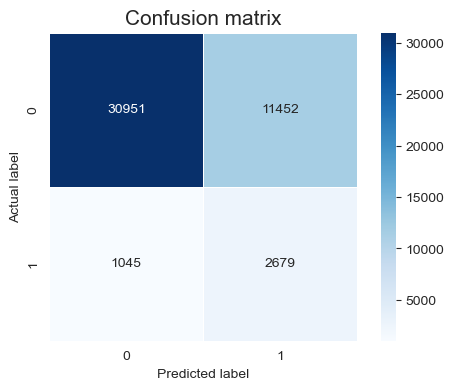


Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.73      0.83     42403
           1       0.19      0.72      0.30      3724

    accuracy                           0.73     46127
   macro avg       0.58      0.72      0.57     46127
weighted avg       0.90      0.73      0.79     46127


In [106]:
trial_params = {'n_estimators': 469,
                'learning_rate': 0.13552339993143445,
                'max_depth': 3,
                'num_leaves': 425,
                'subsample': 0.9661655560883644}


# Initialize the classifier with best params
lgbm_clf = LGBMClassifier(**trial_params,
                          n_jobs=-1,
                          device='gpu',
                          metric='auc',
                          verbosity=0)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('sampler', RandomUnderSampler(sampling_strategy='majority')),
    ('classifier', lgbm_clf)
])

# Concatenate train and validation sets
X_full_train = pd.concat([X_train, X_val])
y_full_train = pd.concat([y_train, y_val])

# Fit the pipeline to the full training data
lgbm_model = pipeline.fit(X_full_train, y_full_train)

# Generate predictions on the test set

lgbm_predictions_proba = lgbm_model.predict_proba(X_test)[:, 1]
lgbm_predictions = lgbm_model.predict(X_test)

auc = roc_auc_score(y_test, lgbm_predictions_proba)
print(f"Final AUC on the test set: {auc}")

# Display confusion matrix and classification report for LGBM
print("LGBM Classifier:")
conf_matrix = my_func.conf_matrix_pred(y_test, lgbm_predictions)
print("\nClassification Report:\n",
      classification_report(y_test, lgbm_predictions, zero_division=0))

The final AUC score on the test set is 0.797, which is quite promising. 
Our model excelled at predicting the low-risk target group, achieving an F1 
score of 0.83. However, it struggled with predicting the high-risk group, with 
an F1 score of only 0.30. The model's overall accuracy on the test data was 73%, 
but this metric is not very reliable for imbalanced data. In the confusion 
matrix, we observed 30,951 True Negatives, 2,679 True Positives, 
1,045 False Negatives, and 11,452 False Positives. 


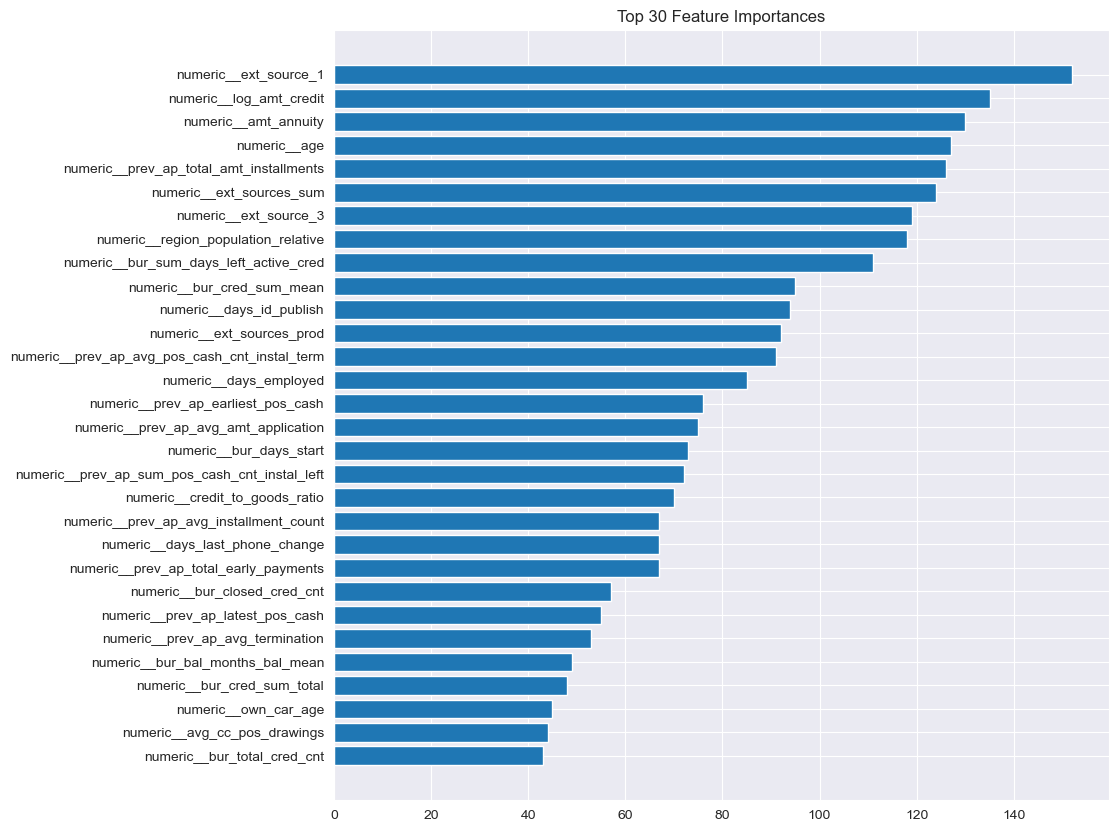

In [73]:
# Extract the LGBM classifier from the pipeline
classifier = lgbm_model.named_steps["classifier"]

# Get feature importances
importances = classifier.feature_importances_
indices = np.argsort(importances)[::-1]

# Get feature names from preprocessor in the pipeline
preprocessor = lgbm_model.named_steps["preprocessor"]
feature_names = preprocessor.get_feature_names_out()

# Select the top 30 features
top_30_idx = indices[:30]
top_30_importances = importances[top_30_idx]
top_30_feature_names = feature_names[top_30_idx]

# Plot the top 30 feature importances
plt.figure(figsize=(10, 10))
plt.title("Top 30 Feature Importances")
plt.barh(range(len(top_30_importances)), top_30_importances)
plt.yticks(range(len(top_30_importances)), [top_30_feature_names[i] for i in range(len(top_30_importances))])
plt.gca().invert_yaxis() 
plt.show()


In [105]:
# Save the model to a file
joblib.dump(lgbm_model, 'lgbm_undersampled.pkl')
lgbm_model = joblib.load('lgbm_undersampled.pkl')

The next steps involve calculating the approximate loss or profit generated by 
our model and considering adjustments to improve its performance.

In [107]:
# Extract predictions from confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()
tn, fp, fn, tp

(30951, 11452, 1045, 2679)

In [108]:
# We assume that the average interest rate is 0.12, default prob 4% and LGD 65%
my_func.calculate_profit_or_loss(
                    conf_matrix=conf_matrix,
                    mean_annuity=application_train['amt_annuity'].mean())


Loss per False Positive prediction: $2710.86
Loss per False Negative prediction: $3307.25
Total Profit from True Negatives: $83903747.11
Total Loss from False Positives: $31044738.84
Total Loss from False Negatives: $3456072.09
Total Profit or Loss: $49402936.18


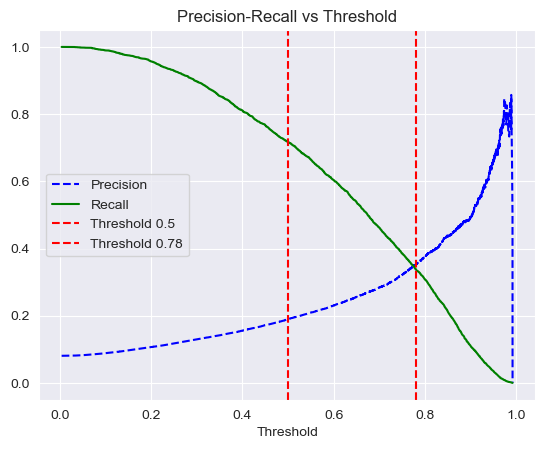

In [68]:
# Calculate precision and recall values
precisions, recalls, thresholds = precision_recall_curve(y_test, lgbm_predictions_proba)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """Draws a Precision-Recall vs Threshold plot"""
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.axvline(x=0.50, color="r", linestyle="--", label="Threshold 0.5")
    plt.axvline(x=0.78, color="r", linestyle="--", label="Threshold 0.78")
    plt.xlabel("Threshold")
    plt.title("Precision-Recall vs Threshold")
    plt.legend()
    plt.show()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

If we adjust our threshold to 0.8, we could get optimal Recall and Precision 
value.

Higher Precision: Fewer False Positives, meaning you're less likely to reject 
low-risk, profitable customers.

Higher Recall: Fewer False Negatives, meaning you're less likely to give loans 
to high-risk customers who may default.

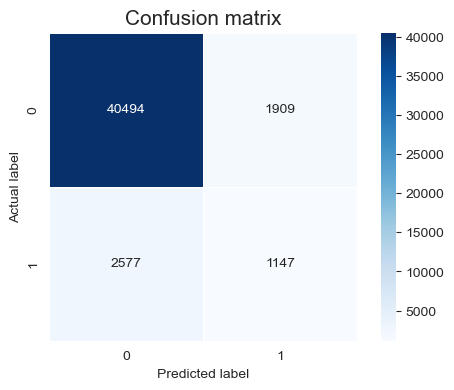

Loss per False Positive prediction: $2710.86
Loss per False Negative prediction: $3307.25
Total Profit from True Negatives: $109773459.19
Total Loss from False Positives: $5175026.76
Total Loss from False Negatives: $8522772.99
Total Profit or Loss: $96075659.44


In [69]:
new_threshold = 0.8

# Make new predictions
new_predictions = (lgbm_predictions_proba >= new_threshold).astype(int)
new_conf_matrix = my_func.conf_matrix_pred(y_test, new_predictions)

# Extract values from the new confusion matrix
my_func.calculate_profit_or_loss(new_conf_matrix, application_train['amt_annuity']
                         .mean())


After increasing the threshold, we can observe changes in our confusion matrix. 
By counting total profit, we can observe a significant increase. 

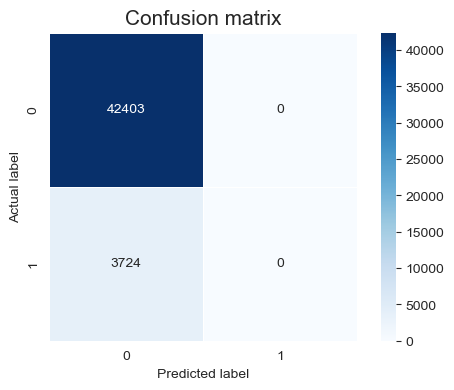

Loss per False Positive prediction: $2710.86
Loss per False Negative prediction: $3307.25
Total Profit from True Negatives: $114948485.95
Total Loss from False Positives: $0.00
Total Loss from False Negatives: $12316184.17
Total Profit or Loss: $102632301.78


In [70]:
new_threshold = 1

# Make new predictions
new_predictions = (lgbm_predictions_proba >= new_threshold).astype(int)
new_conf_matrix = my_func.conf_matrix_pred(y_test, new_predictions)

# Extract values from the new confusion matrix
my_func.calculate_profit_or_loss(new_conf_matrix, application_train['amt_annuity']
                                 .mean())

After setting the threshold to 1, we end up with a naive confusion matrix 
 always predicting a low-risk group. With 42,403 True Negatives and 3,724 False 
Negatives, we can see imbalance of our data. Although our equation indicates 
that the total profit has more than doubled. This naive approach is not a 
viable solution for risk assessment. To get more accurate financial estimates, 
it's crucial to revisit the actual costs of False Positives and False Negatives 
in consultation with the business team. 

In its current state, the model would likely result in more financial loss than 
gain.

# Summary

### Predictions:

Our model scored a promising ROC_AUC of 0.797. This metric reflects the 
model's ability to distinguish between low and high-risk groups. The F1 
score for predicting low-risk targets was excellent at 0.83. However, it 
struggled with predicting the high-risk group, with a F1 score of only 0.30.
 The overall accuracy was 0.73, which is not a reliable metric for our 
imbalanced dataset. Despite its promising features, the model underperformed 
in profit calculations compared to a naive approach that classifies everyone 
as low-risk. It's essential to re-evaluate the financial implications of 
False Positives and False Negatives with the business team.

### Further Improvements:

- Collect more targeted data to balance the minority classes.
- Assess the model's performance without data cleaning to gauge its
  impact on accuracy.
- Experiment with feature engineering to uncover new patterns that could
  be relevant to the target group.
- Revisit data aggregation methods to extract more meaningful data.
- Optimize the classification threshold to balance False Positive and
  False Negative rates effectively.
